In [32]:
#Read in new 0910 cats uploaded by Adam to git
#This does all the merging and mag correction, need to run in Rotate_PreGordo_cat_all for xprime yprint
#separately did region assignment for photometry mask so don't overwrite the new cat_all_PG

import pandas as pd
import numpy as np
import matplotlib.pyplot as py
import sys,os
%pylab inline
#import astropy.io.fits as pyfits
import cluster_tools.CAT as CAT
import cluster_tools.tools as tools
import cluster_tools.cosmo as cosmos
import cluster_tools.Cluster_functs as t
reload(t)
import pickle
import cluster_tools.CalcVelDisp_bcl_edit as v
#reload(t)
#import numpy
import scipy.integrate
import mpld3
from IPython.display import Image, display

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [33]:
#reduces by use flag, removes -1 from crossmatch, cabut not by T08 mask

filepath='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cat_git_worked/'
filepatho='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/'

cat_g=pd.read_csv(filepath+'cl0910+5422_v0.0.3.crossmatch',sep='\s+')
cat_mag=pd.read_csv(filepath+'cl0910+5422_v0.0.3.mag',sep='\s+')
cat_pz=pd.read_csv(filepath+'cl0910+5422_v0.0.3.zout',sep='\s+')
cat_pzb=pd.read_csv(filepath+'rxj0910.P_inclus.dat',sep='\s+',header=None) #no header so don't skip first line, index is line to match

cat_uvb=pd.read_csv(filepath+'cl0910+5422_v0.0.3.restframe',sep='\s+')
cat_uvb['z_uvb']=cat_uvb['z'] #keep redshift used for restframe UVB stored as something else for merge
cat_uvb.drop('z',axis=1,inplace=True)
#id  z  DM  restflux_NUV  errflux_NUV  restflux_U  errflux_U  restflux_B  errflux_B  restflux_V  errflux_V  restflux_r  errflux_r  restflux_J  errflux_J  restflux_2800  errflux_2800
#MNUV-R vs R-J

#Drop z so can merge without creating a ton of duplicates
#  id  z  DM  restflux_NUV  errflux_NUV  restflux_U  errflux_U  restflux_B  errflux_B  restflux_V  errflux_V  restflux_r  errflux_r  restflux_J  errflux_J  restflux_2800  errflux_2800

#read these in and merge for average in each bin (and std) groupby and spit out properties
#SFRs fir.SFR_UVIR (from restframe)
#ltau         log(tau / yr) for SFH
#metal        Metallicity
#lage         log(age/yr)
#Av           V-band attenuation in magnitudes
#lmass        log(mass / Msol)
#lsfr         log(SFR / [Msol/yr])
#lssfr        log(SFR / mass)
#la2t         log(age / tau)

fout=['id','ltau','metal','lage','Av','lmass','lsfr','lssfr','la2t','l68_lmass','u68_lmass','l68_lsfr','u68_lsfr','l68_lssfr','u68_lssfr']

zout=['id','z_peak','l68','u68','l95','u95','dds']
#fout=['id','SFR_UVIR'] #z_peak in this cat has been replaced with z_spec when avail, [Msol / yr]
cat_fir=pd.read_csv(filepath+'cl0910+5422_v0.0.3.fir',sep='\s+')
firout=['id', 'ftot_mips24', 'etot_mips24', 'weight_mips24', 'LIR', 'L2800', 'SFR_UVIR']

cat_fout=pd.read_csv(filepath+'cl0910+5422_v0.0.3.fout',sep='\s+')
#*.fir              Far-IR rate catalog [sc1604]
#*.fout             SPS catalog
cat_o=pd.read_csv(filepatho+'FINAL.spectroscopic.autocompile.blemaux.sc0910.feb2016.plusT08.nodups.cat',sep=r'\s+|\t|[ ]{2,}')

#cat_o.ID.map(lambda x: isinstance(x,str))
#cat_all[cat_all.id_spec.map(lambda x: isinstance(x,str))].id_spec.dropna().values
#match s for slit
#cat_o.slit.str.extract('([0-9]+)(s)').dropna() #extract 41 serendips
'''
I am relabeling this in Brian's cat with an 's' even though there isn't a spectrum spec1d file
The redshift is out of our range so we won't use the spectrum on the photometry for the completeness
As long as photoz cut doesn't go to 0.62
In [233]: cat_o[cat_o.ID=='6079']
       ID maskname slit      LFC_RA    LFC_DEC        r        i      z  \
820  6079   0910HT   93  137.678061  54.370531  21.9618  20.6395  20.14   
821  6079   0910HT   93  137.678061  54.370531  21.9618  20.6395  20.14   

     redshift   red_err  q   old_id  \
820  0.620294  0.000043  4  nooldid   
821  5.221100 -5.000000  2  nooldid   
cat_g[cat_g.id_spec=='6079']
    id_spec slitmask slitnum    ra_spec   dec_spec    z_spec  z_spec_err  Q  \
820    6079   0910HT      93  137.67799  54.370448  0.620294    0.000043  4   
821    6079   0910HT      93  137.67799  54.370448  5.221100   -5.000000  2   

     id_phot     ra_phot   dec_phot  nmatch  blend    ID maskname  
820    52631  137.677883  54.370374       1      0  6079   0910HT  
821    52631  137.677883  54.370374       1      1  6079   0910HT 
                                           notes slitmask slitnum  
820                       Hb/OIII,_supser_Lya?!?   0910HT      93  
821  Lya?!_great_asymmetry_in_1d/2d,_bright,_Q=3   0910HT      93  

So, when outer merge these duplicate adding two objects, one set with each comment
Not sure which one the photometry goes with, the low Q=2 one is blended...I guess I will manually add s to that one 
'''

#cat_o=pd.read_csv(filepatho+'FINAL.spectroscopic.autocompile.blemaux.sc0910.feb2016.plusT08.nodups.cat',header=False,skiprows=0,names=['ID', 'maskname', 'slit', 'LFC_RA', 'LFC_DEC', 'r', 'i', 'z', 'redshift', 'red_err', 'q', 'old_id', 'notes'], sep=r'\t|[ ]{1,}')
#cat_o=pd.read_csv(filepatho+'FINAL.spectroscopic.autocompile.blemaux.sc0910.feb2016.plusT08.nodups.cat',header=False,skiprows=0, sep=r'\t|[ ]{1,}[[ ]{2,}]')
#column names change mask to maskname, Q to q
#Had to correct Brian's cat for a few things..notes spaces and potentially serendip row spaces without current workaround
#cat_o['id_spec']=cat_o['ID'] #old cat ID is spec id, no phot id, no id
#cat_g['id']=cat_g['id_phot'] #already has id_spec and id_phot but no id. For matching phot later 
                            #Note that many id_phot = -1 if there's no match
                            #Should be able to match comments in old cat to spec id in new crossmatch
                            #Match crossmatch phot_id to mag/pz phot_id WHERE !=-1
#cat_o['slitmask']=cat_o['maskname'] 
#cat_g['slit']=cat_g['slit'] 
#cat_g.q=cat_g.q.astype('int64')

#Could also match
#Could just 
#Note I changed one duplicate by adding 's' so both catalogs
#I could just get rid of this with inner merge, since it wasn't a target and has a low q spectra and blended photometry
cat_g=cat_g.merge(cat_o[['id_spec','old_id','slit','maskname','comments']],on=['id_spec','slit','maskname'],how='outer')
cat_mag.set_index('id',drop=False,inplace=True) #Need to match this to crossmatch for specids, inner
cat_pz.set_index('id',drop=False,inplace=True)
cat_fir.set_index('id',drop=False,inplace=True)
cat_fout.set_index('id',drop=False,inplace=True)
cat_uvb.set_index('id',drop=False,inplace=True)

#There is no 0th 'id' so must shift ahead of index


cat_pzb.reset_index(inplace=True)
cat_pzb.columns=['id','pzcdf']
cat_pzb['id']=cat_pzb['id']+1
cat_pzb.set_index('id',drop=False,inplace=True)

#id  z  DM  restflux_NUV  errflux_NUV  restflux_U  errflux_U  restflux_B  errflux_B  restflux_V  errflux_V  restflux_r  errflux_r  restflux_J  errflux_J  restflux_2800  errflux_2800


#names=['ID', 'maskname', 'slit', 'LFC_RA', 'LFC_DEC', 'r', 'i', 'z', 'redshift', 'red_err', 'q', 'old_id', 'notes'], sep=r'\t|\s\s+')
#cat_g.set_index(['ID', 'maskname', 'slit','q', 'old_id'],drop=False,inplace=True)
#cat_gq=cat_g[(cat_g.q>2)&(cat_g.redshift>=1.09)&(cat_g.redshift<=1.12)&(cat_g.z<24.0)]
#cat_gq=cat_g[(cat_g.q>2)&(cat_g.redshift>=1.09)&(cat_g.redshift<=1.12)].redshift.hist(bins=70)
#cat_gq.ID=cat_gq.ID.astype('int64')
#cat_g.q=cat_g.q.astype('int64')
#cat_gq.old_id=cat_gq.old_id.astype('int64')
#cat_gq.maskname=cat_gq.maskname.astype('str')
#cat_o.i=cat_o.i.astype('float64')
#cat_o.r=cat_o.r.astype('float64')
#cat_gq.red_err=cat_gq.red_err.astype('float64')
#cat_gq.set_index(['ID', 'maskname', 'slit','q', 'old_id'],drop=False,inplace=True)
#For now til fix LRIS T08 missing mask folder issue, remove the one file:
#cat_gq=cat_gq[cat_gq.maskname!='T08_LRIS']
#Note z=-5.000 means bad interpolation over chip gap between red and blue, sub in similar i band zerr on same mask
cat_mag['I']=cat_mag.magaper_Iplus + cat_mag.apercorr #There are lots of inf values with use=1...? not -99
cat_mag['R']=cat_mag.magaper_Rc + cat_mag.apercorr
cat_mag['Z']=cat_mag.magaper_Zplus + cat_mag.apercorr
cat_mag['J']=cat_mag.magaper_J + cat_mag.apercorr
cat_mag['K']=cat_mag.magaper_K + cat_mag.apercorr
cat_mag['B']=cat_mag.magaper_B + cat_mag.apercorr
cat_mag['Berr']=cat_mag.erraper_B
cat_mag['Jerr']=cat_mag.erraper_J
cat_mag['Kerr']=cat_mag.erraper_K
#sig(a+x)=sqrt( 1* sig(x)**2 + 1*sig(a)**2 ) Add in quad...but is there an apercorr error?
cat_mag['Ierr']=cat_mag.erraper_Iplus# + cat_mag.apercorr #There are lots of inf values with use=1...? not 
cat_mag['Rerr']=cat_mag.erraper_Rc# + cat_mag.apercorr #There are lots of inf values with use=1...? not 
cat_mag['Zerr']=cat_mag.erraper_Zplus# + cat_mag.apercorr #There are lots of inf values with use=1...? not 
cat_mag['IZ']=cat_mag['I']-cat_mag['Z']
cat_mag['RZ']=cat_mag['R']-cat_mag['Z']
cat_mag['RI']=cat_mag['R']-cat_mag['I']
cat_mag['RIerr']=np.sqrt( cat_mag['Rerr']**2 + cat_mag['Ierr']**2 )
cat_mag['IZerr']=np.sqrt( cat_mag['Ierr']**2 + cat_mag['Zerr']**2 )
cat_mag['RZerr']=np.sqrt( cat_mag['Rerr']**2 + cat_mag['Zerr']**2 )

#

#Merging new .crossmatch with old spec for LFCriz in id_spec, .crossmatch also has id_phot...

#Merge line-matched cats with mags and photozs
#What are objects with null z_peak? They all have use=0
#Only do index True if merging on id where certain about index matches
#cat_mpz.set_index('id',drop=False,inplace=True)
#mag=['R','I','Z','apercorr']
print 'Should be 94037',cat_mag.id.count()
print 'Should be 94037',cat_pz.id.count()

cat_mpz=cat_mag.merge(cat_pz[['id','z_peak','z_spec']],how='outer',left_index=True,right_index=True,on='id',suffixes=('_mag','_zout'))
#cat_mpz=cat_mpz.merge(cat_fir[fir],how='outer',left_index=True,right_index=True,on='id',suffixes=('_mag','_fir'))
print 'Should be 94037 merged mag and pz',cat_mpz.id.count()

print 'Should be 94037 pzb',cat_pzb.id.count()

#print cat_pzb.head(),cat_pzb.tail()
#print cat_mpz.head(),cat_mpz.tail()

cat_mpz=cat_mpz.merge(cat_pzb, how='outer',left_index=True,right_index=True,on='id')
print 'Should be 94037',cat_mpz.id.count()
#print cat_mpz.head(),cat_mpz.tail()

cat_mpz=cat_mpz.merge(cat_uvb, how='outer',left_index=True,right_index=True,on='id')

print 'Should be 94037',cat_mpz.id.count()


cat_mpz=cat_mpz.merge(cat_fout[fout],how='outer',left_index=True,right_index=True,on='id',suffixes=('_mag','_fout'))
print 'Should be 94037',cat_mpz.id.count()


#fir=['id', 'ftot_mips24', 'etot_mips24', 'weight_mips24', 'LIR L2800', 'SFR_UVIR']
cat_mpz=cat_mpz.merge(cat_fir[firout],how='outer',left_index=True,right_index=True,on='id')
print 'Should be 94037',cat_mpz.id.count()





#print 'Should be 94037',cat_mpz.id.count()
#There are 36 spec that have id_phot matches with use=0, 20 stars, 3 lowq, 13 hq, none in cz
#Probably more that just have inf/null RIZ (3 in our clusters)
#These should be the equivalent of id_phot=-1?
cat_mpz=cat_mpz[cat_mpz.use==1] #removes 2725 objects. This may get rid of id_phot objects in spec cat that don't have matches
cat_mpz['id_phot']=cat_mpz['id'] #id from photometric cat will be null but 22 id_phot from cat_o will be -1

#Note that id is currently the index of mpz, but disgards 
#36 id_phot non-null use=0 and 22 id_phot = -1 = 58 objects with spectra but no match
#Replace the id of all objects that have null id with -1
#I may have to re-do this when I get B-band, although this will just give better photozs
print 'number of spec objects matched to phot objects with use=0 flag',cat_g[cat_g.id_phot.isin(cat_mag[cat_mag.use==0].id)][['q','z_spec']].count()
print 'number of spec objects with no photid match',cat_g[cat_g.id_phot==-1].info()


#When merge outer, id_phot=-1 objects in spec catalog will have null 'id', 
#the id_phot in the id_spec/crossmatch catalog is -1 and adds new entries (41) to final merged cat
#There will be many null id_spec with non-null id_phot
#So, after merge must set the null 'id' id_phots with -1
cat_all=cat_mpz.merge(cat_g,how='outer',on=['id_phot'],suffixes=('_mag','_spec'))

print 'objects with no use=0 photometric match: ',cat_all[cat_all.id.isnull()][['id','id_phot','id_spec']].count()
print 'replacing the id index where null with with -1 (from now on ignore id_phot for these values)'
cat_all['id'].fillna(-1,inplace=True)
print 'replacing the ra, dec for -1/use=0 with ra/dec_spec (from now on ignore id_phot for these values)'
#Note keeping null in LFC ra and dec, just replacing for plotting hopefully this skips objects without spectra because they don't have RIZ
#When I do ra&dec plot of pz objects with out a redshift cut (all pz objects), will plot spec objects with no id_phot
#So, maybe do a cut of cat_all.id_phot>0
#cat_all[cat_all.LFC_RA.isnull()].LFC_RA.fillna(cat_all.ra_spec)
#cat_all[cat_all.ra.isnull()].ra.fillna(cat_all.ra_spec,inplace=True)
#cat_all[cat_all.dec.isnull()].dec.fillna(cat_all.dec_spec,inplace=True)
cat_all.ra.fillna(cat_all.ra_spec,inplace=True)
cat_all.dec.fillna(cat_all.dec_spec,inplace=True)

cat_all['redshift']=cat_all['z_spec'] #just doing this for future use/output with other programs
cat_all['quality']=cat_all['q']
cat_all['LFC_RA']=cat_all['ra']
cat_all['LFC_DEC']=cat_all['dec']
#For objects with id_phot=-1, replace LFC_RA and LFC_DEC with ra_spec, dec_spec

#Can't outer join with spec_id because other cats only have spec_z not spec_id, and fewer sigdigs
#If merge with mpz on id_phot only, cat_g spec objects with no match (-1) in outer merge will create new entries, all with -1 index
#Crossmatch cannot match id_phot where -1. Before inner join get rid of these values. 
#When make output cat can make this from full spectral, so insure all spectra used
#prep for merge on id_phot
#cat_g=cat_g[cat_g.id!=-1] #removes 22, so 22 spec objects do not have phot matches, 12 high Q, 3 in cz, 2 we have spectra for
#cat_g.q=cat_g.astype('int64')
#cat_o.q=cat_o.astype('int64')
#cat_g.set_index('id',drop=False,inplace=True) #NOTE ID_PHOT IS -1 FOR NONMATCH
#There might be serendips with same phot_id but at least for ones in our range the photometry matches obj, which is not zpair to won't be double counted in range
#Could be duplicates within our photo range that get counted twice, but they are two objects, even if same slit, even if have same photometry associated will contribute to completeness numbers adequately
#I should outer merge on spec_ID, so phot objects are still there for completeness, and 
#Spec objects with no phot ID will also be added, but with null 
#If index is arbitrary shouldn't matter, will just be null or -1 entries. When set index will matter.
#cat_all=
#cat_mpz.merge(cat_g,how='outer',left_index=True,right_index=True,on=['id_phot'],suffixes=('_mag','_spec'))
#Do this before z_group functions so finds correct column
#cat_all['quality']=cat_all['Q']
#print cat_all.info()
#cat_all['z_spec']=cat_all['z_spec_spec'] 
#cat_all['zphot']=cat_all['z_peak']
#label high quality, redshift range, photo_z redshift range objects
#cat_hqz=cat_all[((cat_all.z_spec<=1.12)&(cat_all.z_spec>=1.09)&(cat_all.Q>2))]
print cat_all.info()

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Should be 94037 94037
Should be 94037 94037
Should be 94037 merged mag and pz 94037
Should be 94037 pzb 94037
Should be 94037 94037
Should be 94037 94037
Should be 94037 94037
Should be 94037 94037
number of spec objects matched to phot objects with use=0 flag q         50
z_spec    50
dtype: int64
number of spec objects with no photid match<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 47 to 976
Data columns (total 15 columns):
id_spec       22 non-null object
maskname      22 non-null object
slit          22 non-null object
ra_spec       22 non-null float64
dec_spec      22 non-null float64
z_spec        22 non-null float64
z_spec_err    22 non-null float64
q             22 non-null float64
id_phot       22 non-null float64
ra_phot       22 non-null float64
dec_phot      22 non-null float64
nmatch        22 non-null float64
blend         22 non-null float64
old_id        22 non-null object
comments      17 non-null object
dtypes: float64(10), object(5)
memory usage: 2.

1.12 1.09
1.2028305 1.0254805 round and re-store as:  1.2 1.03
1.2770305 0.9523305 round and re-store as:  1.28 0.95
q_group
high    702
low     241
star     48
dtype: int64
all quality, for catalog output
z_cut params 1.09 1.12 1.03 1.2 0.95 1.28
z_group
cz    109
nz    882
dtype: int64
z_group_pz2
nz    77270
pz    13023
dtype: int64
z_group_pz
nz    84038
pz     6255
dtype: int64
Changed to Z band cut for PG mag lims: [ 17 23.25 ] spans 6.25
contour N= 25 , # 0 contains: 20292 gals out of 90366


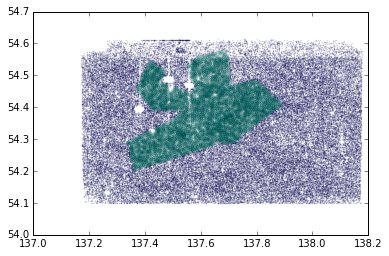

In [34]:

#Now that have all elements, need to figure out shift situation
# median (cat_all.z_spec - cat_all.z_peak)/(1+cat_all.z_peak) is for q=3,4 galaxies, then z_peak_final = z_phot_in + delta*(1+z_peak), 
#Only if Adam doesn't apply this shift to z_peak



#Need to pick a mag cut and do Brian's suggested zphot zspec calculations
#The 1sigma*(1+z) range looks fine to me, but remember to clip out use=0 objects. 
#You also should be clipping out any objects fainter than the limiting magnitude of our spectral sample since we used that to train the photo-zs. 
czmin,czmax=1.09,1.12
z=(1.12-1.09)/2+1.09 #1.105 pm .03 Adam says 1.11 based on zspec rounded?
#sigma=0.083 #sig*(1+z)=0.083 sig~0.04 z=1.11
#zsig=0.039 #Rounded from 0.039 based on our chosen cz range (I rounded this back because sigma has 3 sigdigs)
zsig=0.035 

#Jun 7 shift the mean
#cat_all['z_peak_noshift']=cat_all.z_peak #Note this already stored during first iteration so uncommented
delz=0.0041 #This is an additional shift noticed by me and Brian just for our cluster after we applied the mean shift
#cat_all.z_peak=(cat_all.z_peak + (delz* (1+cat_all.z_spec)))
#Brian says use delz=0.0041, apply to peaks and and pzmin and max
cat_all['z_peak_shift']=(cat_all.z_peak + (delz* (1+cat_all.z_peak)))
cat_all['z_peak']=cat_all['z_peak_shift']

#MAY 16 2016 EDIT: Brian says to add sigma to z_spec boundaries. So adjust. Then at least 68% values should be within the 1sig interval anywhere within the zphot (cz but non-pz 32% outside)
#pzmax=1*sigma+z #probably should compare completeness for 1.5 and 2*sigma
#pzmin=-1*sigma+z #1.022,1.188 versus 2*sigma=[0.939, 1.271]
#Maybe just use Nick's p(z) probability
#pzmax=czmax+1.*zsig*(1+czmax) + (delz* (1+cat_all.z_peak))#probably should compare completeness for 1.5 and 2*sigma
#pzmin=czmin-1.*zsig*(1+czmin) + (delz* (1+cat_all.z_peak))#
#pzmax2=czmax+2.*zsig*(1+czmax) + (delz* (1+cat_all.z_peak))#probably should compare completeness for 1.5 and 2*sigma
#pzmin2=czmin-2.*zsig*(1+czmin) + (delz* (1+cat_all.z_peak))#
pzmax=czmax+1.*zsig*(1+czmax) + (delz* (1+z))#probably should compare completeness for 1.5 and 2*sigma
pzmin=czmin-1.*zsig*(1+czmin) + (delz* (1+z))#
pzmax2=czmax+2.*zsig*(1+czmax) + (delz* (1+z))#probably should compare completeness for 1.5 and 2*sigma
pzmin2=czmin-2.*zsig*(1+czmin) + (delz* (1+z))#

print czmax,czmin
print pzmax,pzmin, 'round and re-store as: ',round(pzmax,2),round(pzmin,2) 
print pzmax2,pzmin2, 'round and re-store as: ',round(pzmax2,2),round(pzmin2,2) 

pzmax,pzmin = round(pzmax,2),round(pzmin,2)
pzmax2,pzmin2 = round(pzmax2,2),round(pzmin2,2)

#1.19 1.02
#1.27 0.94
#(1.19-1.02)/2 pz /pm 0.08499999999999996 (versus spec pm 0.074), should check in other nbk

#cat_all = t.zcut(cat_all ,czmin, czmax, pzmin, pzmax,zcol='redshift') #this does photoz cut too
cat_all = t.qcut(cat_all)
#print 'Only high quality, not star, run here for stats'
#cat_all = t.zcut(cat_all[cat_all.q_group=='high'] ,czmin, czmax, pzmin, pzmax,zcol='redshift') #this does photoz cut too
print 'all quality, for catalog output'
reload(t)


#Apply median shift correction for version 3, store original z_peak values in unshifted
#Take median of values for only q=3,2 in our redshift range (I think I didn't limit this for our field, I may have just done a quality cut...most objects are in our redshift range tho. Brian also said to do a magnitude cut)
#There still appears a residual offset, though, and that should be applied to both the photo-zs and their upper and lower effective 1sigma bounds before doing any calculations. 
#This median offset, the one you quote recovering in 0.5 < z < 1.3, del = 0.0041, is sufficient for your purposes, apply it and move on. And please ask Nick nicely to do the same.

#cat_med=cat_all
#cat_med=cat_med[(cat_med.q_group=='high')&(cat_med.redshift>=czmin)&(cat_med.redshift<=czmax)]
#delz=((cat_med.z_spec-cat_med.z_peak)/(1+cat_med.z_peak)).median()
#-0.010018118987578243
#print delz

#Store old z_peak
#cat_all['z_peak_noshift']=cat_all.z_peak
#cat_all.z_peak=(cat_all.z_peak + (delz* (1+cat_all.z_spec)))
#Brian says use delz=0.0041, apply to peaks and and pzmin and max
#cat_all.z_peak=(cat_all.z_peak + (delz* (1+cat_all.z_peak)))


#cat_all = t.zcut(cat_all ,czmin, czmax, pzmin, pzmax,zcol='redshift') #this does photoz cut too
cat_all = t.zcut_PG(cat_all ,czmin, czmax, pzmin, pzmax,pzmin2, pzmax2,zcol='redshift') #this does photoz cut too

#WHY IS IT THAT 13 HIGH Q SPECZ OBJECTS HAVE NO PHOTOZ/PHOTOINFO yet nmatch=1, useand didn't get filtered out with !=-1
#They must have had  photoid but a use flag of zero, so still put into coadds but no data, NONE are in cluster


magh, magl = 23.25, 17 #~no bright end, neater than 22.91, still gest North 22.86 object
#print 'Running mag sort bright, faint, in', ' [',str(magl),',',str(magh),'].'
cat_all = t.mcut(cat_all, magh, magl) #USES R BAND
#CLIP OUBJECTS FAINTER THAN LIMITING MAG

f='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/region_stuff/contPG.pickle'
cont=pd.read_pickle(f)
grouped=cont.groupby(level=0)
cat_all.id=cat_all.id.astype('int')
cat_all.set_index('id',drop=False,inplace=True)
cat_all['alpha']=cat_all.ra
cat_all['delta']=cat_all.dec
PG_slitmasks=grouped.apply(t.ppoly,cat_all[['id','alpha','delta']])
cat_all=t.reg_contour_PG(cat_all,PG_slitmasks)

py.plot(cat_all[cat_all.region_PG.notnull()].ra,cat_all[cat_all.region_PG.notnull()].dec,'co',ms=2,alpha=0.1)
py.plot(cat_all[cat_all.region_PG.isnull()].ra,cat_all[cat_all.region_PG.isnull()].dec,'bo',ms=1,alpha=0.1)

#So, before any completeness calculations: done in rotate cat
#cat_all=cat_all[cat_all.region_PG.notnull()] 
#OLD
#1.12 1.09
#1.1942 1.01685 round and re-store as:  1.19 1.02
#1.2684 0.9437 round and re-store as:  1.27 0.94

In [50]:

cat_all.R.loc[(cat_all.R<0)]=np.nan
cat_all.I.loc[(cat_all.I<0)]=np.nan
cat_all.Z.loc[(cat_all.Z<0)]=np.nan

cat_all.I=cat_all.I.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_all.R=cat_all.R.replace([np.inf, '-99',-99], np.nan)
cat_all.Z=cat_all.Z.replace([np.inf, '-99',-99], np.nan)

cat_all.IZ=cat_all.IZ.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_all.RZ=cat_all.RZ.replace([np.inf, '-99',-99], np.nan)
cat_all.RI=cat_all.RI.replace([np.inf, '-99',-99], np.nan)

#Do PG region final cut in rotate cat. No longer need height cut done in PG rev3 with new radial binning 

#JUST UNCOMMENTED 
#cat_gq_test_NUVRRJ.tab
cat_all.to_csv('cat_all_PG_NIR.tab',sep='\t',index=False,na_rep='NULL')
#cat_all.set_index()
#Need more than one group to take cross section
cat_all.set_index(['z_group','q_group'],drop=False, inplace=True)

#How many lq, hq, pz, cz objects have infinite or null mags 

#Only eliminate null and inf values for CMD plots, not from coadd sample
#cond=(cat_all.I>'-99')&cat_all.I.notnull()&cat_all.I.notnull()

#Overall sampling, look at hq cz objects with no (-99/-100/, inf) photometric values
#cat_g.groupby('q').size()
#Sampling at our redshift range. 3(IZ)-4(R) hq cz spectra with negative or inf (R) values
#RIZ have three null values
#They have hq, cz specz but nmatch=0 no match in cat...should remove these for coadd
print cat_all.xs(['cz'],level=['z_group']).groupby('q_group').size()
#print '3 Objects in cz with RIZ np.nan (after replacement), all are hq'
#print '1 Object in cz with I inf, for which RZ are -99/-100..., none in RZJK. Is hq'
#print 'Objects in cz with RIZ inf, or -99 being replaced with np.nan'
print cat_all[cat_all.I.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()
print cat_all[cat_all.R.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()
print cat_all[cat_all.Z.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()

#cat_all[cat_all.I.isnull()].xs(['cz'],level=['z_group'])
cat_all[cat_all.R<0].xs(['cz'],level=['z_group'])[['R','I','Z','q_group']].groupby('q_group').size()
#cat_all.xs(['cz'],level=['z_group']).groupby('q_group').size()

#print cat_all[cat_all.R.isnull()|cat_all.I.isnull()|cat_all.Z.isnull()].count()

#There are many negative numbers so replace all negative numbers with np.nan
cat_all[(cat_all.R<0)|(cat_all.I<0)|(cat_all.Z<0)] #1722 phot and 3 spec have negative values
#Replace all negative, inf RIZ with np.nan
cat_all.R.loc[(cat_all.R<0)]=np.nan
cat_all.I.loc[(cat_all.I<0)]=np.nan
cat_all.Z.loc[(cat_all.Z<0)]=np.nan

cat_all.I=cat_all.I.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_all.R=cat_all.R.replace([np.inf, '-99',-99], np.nan)
cat_all.Z=cat_all.Z.replace([np.inf, '-99',-99], np.nan)

cat_all.IZ=cat_all.IZ.replace([np.inf, '-99',-99], np.nan) #8 spec objects have inf I band, 4 hq, 1cz
cat_all.RZ=cat_all.RZ.replace([np.inf, '-99',-99], np.nan)
cat_all.RI=cat_all.RI.replace([np.inf, '-99',-99], np.nan)

onenull=(cat_all.R.isnull()|cat_all.I.isnull()|cat_all.Z.isnull())
print 'With at least one null (cannot use in CMD):'
print cat_all[onenull].groupby(['q_group','z_group']).size()
#print cat_all[onenull].
cond=cat_all.I.notnull()&cat_all.R.notnull()&cat_all.Z.notnull()

print 'With at all not null (can use in CMD):'
#print cat_all[cat_all.R.isnull()|cat_all.I.isnull()|cat_all.Z.isnull()].info()
print cat_all[cond].groupby(['q_group','z_group']).size()
print 'RIZ notnull in cz with hq: 4 total objects, null in I&R, 3 in Z'
#print cat_all[cat_all.I.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()
#print cat_all[cat_all.R.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()
#print cat_all[cat_all.Z.notnull()].xs(['cz'],level=['z_group']).groupby('q_group').size()

#print cat_all[cat_all.R.isnull()].replace([np.inf, '-99',-99], np.nan).xs(['cz'],level=['z_group']).groupby('q_group').size()
#print cat_all[cat_all.Z.isnull()].replace([np.inf, '-99',-99], np.nan).xs(['cz'],level=['z_group']).groupby('q_group').size()

#cat_all.to_csv('cat_all_PG.tab',sep='\t',index=False)

q_group
high    102
low       7
dtype: int64
q_group
high    98
low      7
dtype: int64
q_group
high    98
low      7
dtype: int64
q_group
high    99
low      7
dtype: int64
With at least one null (cannot use in CMD):
q_group  z_group
high     cz          4
         nz         24
low      nz         16
star     nz         35
dtype: int64
With at all not null (can use in CMD):
q_group  z_group
high     cz          98
         nz         576
low      cz           7
         nz         218
star     nz          13
dtype: int64
RIZ notnull in cz with hq: 4 total objects, null in I&R, 3 in Z


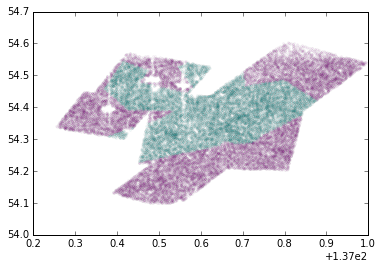

In [36]:
#Now with SFR_UVIR data...
#Coverage looks even over entire field
cat_all.LIR=cat_all.LIR.replace([np.inf, '-99',-99], np.nan)
#sn2=((cat_all.ftot_mips24/cat_all.etot_mips24)>2.0)
PGnotnull=(cat_all.region_PG.notnull())
#cat_mips=cat_all[((cat_all.ftot_mips24/cat_all.etot_mips24)>2.0)] #this gets rid of all values with null for these values already
py.plot(cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.notnull())].ra,cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.notnull())].dec,'co',ms=2,alpha=0.05)
#py.plot(cat_all[(cat_all.region_PG.isnull())&(cat_all.LIR.notnull())].ra,cat_all[(cat_all.region_PG.isnull())&(cat_all.LIR.notnull())].dec,'mo',ms=2,alpha=0.05)
py.plot(cat_all[(cat_all.region_PG.isnull())&(cat_all.LIR.notnull())].ra,cat_all[(cat_all.region_PG.isnull())&(cat_all.LIR.notnull())].dec,'mo',ms=2,alpha=0.05)

#cat_all=cat_all[(cat_all.ftot_mips24/cat_all.etot_mips24>2.0)]

#cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.notnull())][['ra','dec','id_phot']].to_csv('mips_all.cat',s='\s',index=False)
#py.plot(cat_all[cat_all.region_PG.isnull()].ra,cat_all[cat_all.region_PG.isnull()].dec,'bo',ms=1,alpha=0.1)


(array([ 38.,   8.,   9.,  17.,   8.,  16.,  10.,  17.,  16.,  16.,  53.,
         15.,  18.,  22.,  20.,  33.,  15.,  13.,  22.,  45.,  31.,   7.,
         19.,  32.,  17.,  19.,   5.,  94.,  43.,   9.,  17.,  14.,   6.,
         20.,  13.,   8.,   5.,   2.,   1.,   1.,   1.,   2.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.]),
 array([ 0.  ,  0.04,  0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,
         0.36,  0.4 ,  0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,
         0.72,  0.76,  0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ,  1.04,
         1.08,  1.12,  1.16,  1.2 ,  1.24,  1.28,  1.32,  1.36,  1.4 ,
         1.44,  1.48,  1.52,  1.56,  1.6 ,  1.64,  1.68,  1.72,  1.76,
         1.8 ,  1.84,  1.88,  1.92,  1.96,  2.  ]),
 <a list of 50 Patch objects>)

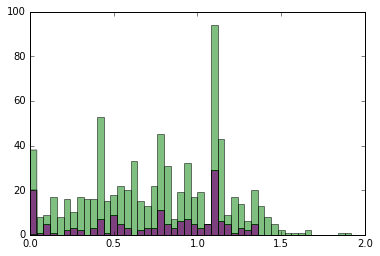

In [37]:
#Looks like photo and spectro coverage is even, though photo peaks at 0.4 and spec peaks around our cluster, which I guess we would expect
#photo
#n,binss,patches=py.hist(cat_all[(cat_all.region_PG.notnull())&(cat_all.SFR_UVIR.notnull())].z_peak.dropna(),bins=70,alpha=0.3,range=[0,2] )
binss=50
#spec redshifts targeted (high and low q) in our slitmask region
py.hist(cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.isnull())].redshift.dropna(),bins=binss,alpha=1,range=[0,2],color='magenta' )

py.hist(cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.notnull())].redshift.dropna(),bins=binss,alpha=0.5,color='green',range=[0,2] )

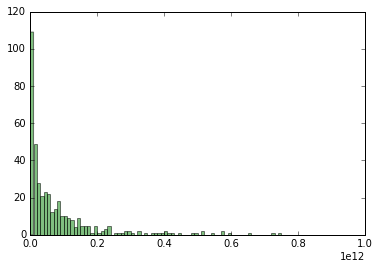

In [38]:
#high quality
binss=100

#py.hist(cat_all[(cat_all.region_PG.notnull())&(cat_all.SFR_UVIR.isnull())&(cat_all.q_group=='high')].SFR_UVIR.dropna(),bins=binss,alpha=1,range=[0,2],color='magenta' )

a,b,c=py.hist(cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.notnull())&(cat_all.q_group=='high')].LIR.dropna(),bins=binss,alpha=0.5,color='green',range=[0,1e12] )


In [39]:
c = 3*10**5 #Units km/s
z=zC=1.105
rvirB=1.01207064831
rvirA=0.820350458861
#rvir = r200/1.14
r200A=rvirA*1.14
r200B=rvirB*1.14
zCB= 1.1024208 #mean redshift B
zCA= 1.1003972 #mean redshift A
sigmaA, sigmaA_err=681.2,170.1
sigmaB, sigmaB_err=840.4,244.0
#CENTROIDS
#CENTROIDS XRAY
#09:10:44.91 +54:22:07.64
raA,decA=137.68712499999998,54.368788888888886
#09:10:08.77 +54:18:58.30
raB,decB=137.53654166666666,54.31619444444444


#raA,decA= 137.68400, 54.372387 #1mpc
#raB,decB= 137.51280, 54.309944 #1mpc


M200A, M200B = 2.91546371993e+14,5.47446715836e+14 #5.47446715836, 2.91546371993
#cat_gq=cat_all

#cat_gq=pd.concat([cat_gq.loc[:,'id':'dec'], cat_gq.loc[:,'star':]],axis=1)
cat_all.set_index(['id','z_group','q_group'],drop=False,inplace=True)
cat_gq=cat_all[cat_all.region_PG.notnull()] #remove photometric objects outside slitmask area for accurate completeness statistics

cat_gq['LFC_RA']=cat_gq.ra
cat_gq['LFC_dec']=cat_gq.dec

#This is so can apply slices to members subsets, or do groupby radially cut composites
#to not exclude members from other cluster, do (members within A| members within B)
#do distance cut, for A and B centers, could change to zA, zB
raA,decA= 137.68400, 54.372387 #1mpc
raB,decB= 137.51280, 54.309944 #1mpc
f=lambda a,b: tools.angdist(a,b,raA,decA)*60*60
fMpc=lambda a,b: tools.angdist(a,b,raA,decA)*60*cosmos.ProjectedLength(z)
cat_gq['dA']=map(f,cat_gq.LFC_RA,cat_gq.LFC_DEC)
cat_gq['dAMpc']=map(fMpc,cat_gq.LFC_RA,cat_gq.LFC_DEC)
f=lambda a,b: tools.angdist(a,b,raB,decB)*60*60
fMpc=lambda a,b: tools.angdist(a,b,raB,decB)*60*cosmos.ProjectedLength(z)
cat_gq['dB']=map(f,cat_gq.LFC_RA,cat_gq.LFC_DEC)
cat_gq['dBMpc']=map(fMpc,cat_gq.LFC_RA,cat_gq.LFC_DEC)
#blah=py.hist(cat_gq.dAMpc[cat_gq.dAMpc<2*rvirA],bins=10)


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

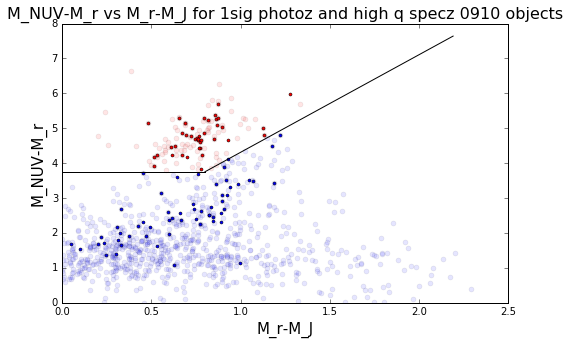

In [40]:
#INCLUDE ACTIVE PASSIVE DIVIDE HERE
#COPIED FROM RORATE_NUVRRJ. I couldn't read this in because need to do 2 sigma cut for LTIR analysis 
cat_gq.set_index(['id'],drop=False,inplace=True)
#cat_gq.set_index(['id','z_group','q_group'],drop=False,inplace=True)
#-2.5 * log10( flux ) + 25
DM=43.5250505050505 #mean DM for LSS hq objects
zp=25.0
f=lambda x: - 2.5*np.log10(x) - DM + zp
cat_gq['M_NUV']=map(f,cat_gq['restflux_NUV'])
cat_gq['M_r']=map(f,cat_gq['restflux_r'])
cat_gq['M_J']=map(f,cat_gq['restflux_J'])

cat_gq['MNUVMr']=cat_gq['M_NUV']-cat_gq['M_r'] #y
cat_gq['MrMJ']=cat_gq['M_r']-cat_gq['M_J'] #x
cat_gq['gtype']=pd.Series(np.repeat(np.array(['active']),len(cat_gq)), index=cat_gq.index)
m,y0=2.8,1.51
x_cut=0.8 #MRMJ cut for quiescence: gt has linear y cut, leq has linear cut 
y_cut=3.75
f = lambda y, x : y - x * m #substract slope from each point based on x value
cat_gq['MNUVMr_mod'] = map(f , cat_gq['MNUVMr'], cat_gq['MrMJ'])

#py.plot(cat_gq['M_r']-cat_gq['M_J'] ,cat_gq['M_NUV']-cat_gq['M_r'],'bo',ms=3,alpha=0.1)
#py.plot(cat_gq['MrMJ'] ,cat_gq['MNUVMr'],'ro',ms=1,alpha=0.2)
#py.savefig('MNURRRJ_all.png')

#cat_gq['MNUVMr_mod']=pd.Series(np.repeat(np.array(['np.nan']),len(cat_gq)), index=cat_gq.index)
#mpld3.enable_notebook()
py.rcParams['figure.figsize'] = (8, 5)
#%pylab inline

criterion1 = cat_gq['MNUVMr_mod'].map(lambda x: x>=y0) # gt y0 for gt 0.8 
criterion2 = cat_gq['MrMJ'].map(lambda x: x>x_cut) # gt 0.8 
criterion3 = cat_gq['MNUVMr'].map(lambda x: x>=y_cut) # gt y_cut for 
criterion4 = cat_gq['MrMJ'].map(lambda x: x<=x_cut) #lteq 0.8  geq

cat_gq.loc[criterion1&criterion2,'gtype']='quiescent'
cat_gq.loc[criterion3&criterion4,'gtype']='quiescent'

#cat_gq.to_csv('cat_gq_test_NUVRRJ.tab',sep='\t',index=False)
cat_gq.set_index(['id','z_group','z_group_pz','q_group','gtype'],drop=False,inplace=True)

#cat_gq.groupby(['q_group','z_group','gtype']).size()
py.plot(cat_gq.xs(['active','pz'],level=['gtype','z_group_pz']).MrMJ, cat_gq.xs(['active','pz'],level=['gtype','z_group_pz']).MNUVMr,'bo',ms=5,alpha=.1)
py.plot(cat_gq.xs(['quiescent','pz'],level=['gtype','z_group_pz']).MrMJ, cat_gq.xs(['quiescent','pz'],level=['gtype','z_group_pz']).MNUVMr,'ro',ms=5,alpha=.1)
py.plot(cat_gq.xs(['active','cz','high'],level=['gtype','z_group','q_group']).MrMJ, cat_gq.xs(['active','cz','high'],level=['gtype','z_group','q_group']).MNUVMr,'bo',ms=3,alpha=1)
py.plot(cat_gq.xs(['quiescent','cz','high'],level=['gtype','z_group','q_group']).MrMJ, cat_gq.xs(['quiescent','cz','high'],level=['gtype','z_group','q_group']).MNUVMr,'ro',ms=3,alpha=1)
#py.plot(cat_gq.xs(['active'],level=['gtype']).MrMJ, cat_gq.xs(['active'],level=['gtype']).MNUVMr,'bo',ms=2,alpha=.3)
#py.plot(cat_gq.xs(['quiescent'],level=['gtype']).MrMJ, cat_gq.xs(['quiescent'],level=['gtype']).MNUVMr,'ro',ms=5,alpha=.3)
#py.xlim([0,2])
#py.ylim([0,8])
x=np.arange(0.8,2.2,.01)
y=y0+2.8*x #1.51 is intercept, m is slope
py.plot(x,y,'k-') # line starting at x=0.8 increasing to inf 
#y=np.arange(0,3.75,.01)
#x=y*0.0+x_cut
#py.plot(x,y,'k--') #plots constant x line of 0.8 dividing slopes
x=np.arange(0,x_cut+0.01,.01)
y=y_cut+x*0.0 #3.75
py.plot(x,y,'k-') #plots constant y line, should stop at x_cut
py.xlim([0,2.5])
py.ylim([0,8])
py.ylabel('M_NUV-M_r',fontsize=15)
py.xlabel('M_r-M_J',fontsize=15)
py.title('M_NUV-M_r vs M_r-M_J for 1sig photoz and high q specz 0910 objects',fontsize=16)
#py.ylabel(r'$M_{NUV}-M_{r}$',fontsize=20)
#py.xlabel(r'$M_{r}-M_{J}$',fontsize=20)
#py.savefig('MNURRRJ_pzczhq.png')


In [41]:
#NOW REMOVE ALL QUIESCENT

#EDIT ADD
#edit feb 8 to make cats, temp removed active...I think LIR is in here
#Feb 11, for some reason this is outputting curtailed cats for MF and MB, so maybe rerun the whole thing
#cat_gq=cat_gq[cat_gq.gtype=='active']

#folder='Rvir_radialg4'
folder='Rvir_radialg4_NUVRRJ'


targetdir='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/cats_groupby/'+folder+'/'

core_condA, core_condB=(cat_gq.dAMpc<0.5*rvirA),(cat_gq.dBMpc<0.5*rvirB)
annulus_condA,annulus_condB=((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),(cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)
print 'This will not wor if I have index of id because there are duplicates...I think groupby keeps index'
cat_gq.reset_index(inplace=True,drop=True)

#grouped_xbins_i = cat_gq.groupby(pd.cut(cat_gq.xprime,bins,labels=[str(i+1) for i in arange(len(bins)-1)]))
#cat_gq['slice_i']=pd.Series(np.repeat(np.array('no slice'),len(cat_gq)), index=cat_gq.index)
#for a in [str(i+1) for i in arange(len(bins)-1)]:
#    cat_gq['slice_i'].loc[grouped_xbins_i.get_group(a).index]=a

#print cat_gq.groupby('slice_i').size()
#print 'grouped_xbins_i bins now labeled by number right to left, in image'

labels=['merger back','infall B','core B','merger front','infall A','core A'] #conpare 1+13 to see how diff they are

bins3=['1','2','3','4','5','6'] #This is to assign new bin numbers for coadd program if don't want to use string names

#bins2=[['1','13'],['2','3','4','5','6'],['2','3','4','5','6'],['7'],['8','9','10','11','12'],['8','9','10','11','12'] ]
colors=['bo','ro','co','go','mo','yo']
#cat_gq['slice']=pd.Series(np.repeat(np.array('unassigned'),len(cat_gq)), index=cat_gq.index)
#cat_gq['slice_i2']=pd.Series(np.repeat(np.array('7'),len(cat_gq)), index=cat_gq.index) #Could change this back to string
#cat_gq['slice_i34']=pd.Series(np.repeat(np.array('non'),len(cat_gq)), index=cat_gq.index) #Could change this back to string

dic=dict(zip(labels, bins3)) #probably easier just to zip all when iterating because dict only has one def

#REV3 EDIT: NEW BIN FOR MERGER FRONT AND MERGER BACK APPROX
#will this overlap with unassigned/merger back? This may screw with binned plotting

#THIS WILL OVERWRITE HALO A POINTS WITH HALO B OUTER RADIUS SO CHANGE ORDER OR ADD CONDITION
cat_gq.loc[( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i34']='merger front 3p5'
#cat_gq.loc[((cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ),'slice_i2']=
#MFX=3.5
MFX=4.0

#NEW definition of MERGER BACK, removed above linear string assignment for slice
#Objects within 4*Rvir but greater than 1.5*Rvir (annulus same as merger front, but NOT in merger front)
cat_gq.loc[( ((cat_gq.dBMpc<=MFX*rvirB)&(cat_gq.dBMpc>1.5*rvirB)) | ((cat_gq.dAMpc<=MFX*rvirA)&(cat_gq.dAMpc>1.5*rvirA)) ),'slice']='merger back'
cat_gq.loc[( ((cat_gq.dBMpc<=MFX*rvirB)&(cat_gq.dBMpc>1.5*rvirB)) | ((cat_gq.dAMpc<=MFX*rvirA)&(cat_gq.dAMpc>1.5*rvirA)) ),'slice_i2']=dic['merger back']


cat_gq.loc[( (cat_gq.dBMpc<=MFX*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=MFX*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice']='merger front'
cat_gq.loc[( (cat_gq.dAMpc<=MFX*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=MFX*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ),'slice_i2']=dic['merger front']

cat_gq.loc[(~( (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ) ) & ( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i34']='merger front 3_4'
#cat_gq.loc[(~( (cat_gq.dAMpc<=3.5*rvirA)&(cat_gq.dAMpc>1.5*rvirA) & (cat_gq.dBMpc<=3.5*rvirB)&(cat_gq.dBMpc>1.5*rvirB) ) ) & ( (cat_gq.dBMpc<=4.0*rvirB)&(cat_gq.dBMpc>1.5*rvirB) & (cat_gq.dAMpc<=4.0*rvirA)&(cat_gq.dAMpc>1.5*rvirA) ),'slice_i2']=dic['merger front']


cat_gq.loc[((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)),'slice']='infall B'
cat_gq.loc[((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),'slice']='infall A'
cat_gq.loc[(cat_gq.dBMpc<0.5*rvirB),['slice']]='core B'
cat_gq.loc[(cat_gq.dAMpc<0.5*rvirA),['slice']]='core A'

cat_gq.loc[((cat_gq.dBMpc<=1.5*rvirB)&(cat_gq.dBMpc>0.5*rvirB)),'slice_i2']=dic['infall B']
cat_gq.loc[((cat_gq.dAMpc<=1.5*rvirA)&(cat_gq.dAMpc>0.5*rvirA)),'slice_i2']=dic['infall A']
cat_gq.loc[(cat_gq.dBMpc<0.5*rvirB),['slice_i2']]=dic['core B']
cat_gq.loc[(cat_gq.dAMpc<0.5*rvirA),['slice_i2']]=dic['core A']


#.map(lambda x: if x equals 'B CORE')
print cat_gq.groupby('slice').size()



This will not wor if I have index of id because there are duplicates...I think groupby keeps index
slice
core A           156
core B           188
infall A        1011
infall B        1360
merger back     7725
merger front    2049
dtype: int64


In [49]:
#cat_gq.to_csv('cat_gq_NUVRRJ.tab',sep='\t',index=False,na_rep='NULL')

#MAKE CATS
#RERUN WITHOUT ACTIVE CUT, check numbers
#haven't cut out T08, AGN, null mag objects
#The id = -1 objects are at the end, spectra but no phot match
#replace null values
cat_gq.set_index(['slice','z_group','q_group','z_group_pz','z_group_pz2'],drop=False,inplace=True)
#print cat_gq.xs(['cz','high','merger front'],level=['z_group','q_group','slice'])
#print cat_gq.xs(['cz','high','merger front'],level=['z_group','q_group','slice']).to_csv('MF_all.tab',index=False,sep='\t')
print cat_gq.xs(['merger front'],level=['slice']).to_csv('MF_all.tab',index=False,sep='\t',na_rep='NULL')
print cat_gq.xs(['merger back'],level=['slice']).to_csv('MB_all.tab',index=False,sep='\t',na_rep='NULL')
print cat_gq.xs(['cz','high','merger front'],level=['z_group','q_group','slice']).to_csv('MF_hqcz.tab',index=False,sep='\t',na_rep='NULL')
print cat_gq.xs(['cz','high','merger back'],level=['z_group','q_group','slice']).to_csv('MB_hqcz.tab',index=False,sep='\t',na_rep='NULL')
print cat_gq.xs(['merger front','pz'],level=['slice','z_group_pz2']).to_csv('MF_pz2.tab',index=False,sep='\t',na_rep='NULL')
print cat_gq.xs(['merger back','pz'],level=['slice','z_group_pz2']).to_csv('MB_pz2.tab',index=False,sep='\t',na_rep='NULL')

#print cat_gq.loc['merger front']

None
None
None
None
None
None


using dic (zip of bins3 and labels manually spec), will not plot unassigned {'infall B': '2', 'infall A': '5', 'core B': '3', 'core A': '6', 'merger back': '1', 'merger front': '4'}
plotting merger back 1
plotting infall B 2
plotting core B 3
plotting merger front 4
plotting infall A 5
plotting core A 6
1 ['1'] ['merger back'] 28
2 ['2'] ['infall B'] 18
3 ['3'] ['core B'] 9
4 ['4'] ['merger front'] 19
5 ['5'] ['infall A'] 17
6 ['6'] ['core A'] 8


1 ['1'] ['merger back'] 8
2 ['2'] ['infall B'] 17
3 ['3'] ['core B'] 9
4 ['4'] ['merger front'] 18
5 ['5'] ['infall A'] 16
6 ['6'] ['core A'] 8
41227335077.9
merger front mean 48491920611.1
merger back mean 2.802400125e+11
merger front median 13363650000.0
merger back median 85611450000.0


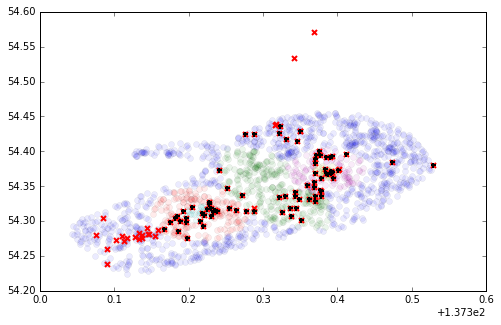

In [45]:
mpld3.enable_notebook()


#Have to read in pickle file here

#cat_gq=cat_gq[(cat_gq.Z<=23.25)&(cat_gq.Z>=20.0)]
mag=((cat_gq.Z<=23.25)&(cat_gq.Z>=20.0))
#t.cont_plot(grouped,False)
sn2=((cat_gq.ftot_mips24/cat_gq.etot_mips24)>2.0)

#cat_gq.set_index(['z_group','q_group','z_group_pz'],drop=False,inplace=True)
cat_gq.set_index(['z_group','q_group','slice','z_group_pz','z_group_pz2'],drop=False,inplace=True)

print 'using dic (zip of bins3 and labels manually spec), will not plot unassigned',dic
#Still have to replace tis loop with inverse dic zip(colors,labels): for num in nums: print dic[num],num
for a,b,c in zip(labels,colors,bins3): #THIS WONT PLOT UNASSIGNED (which has tons/all of the un assigned photoz gals)  
    print 'plotting',a,c
    py.plot(cat_gq[(cat_gq.slice==a)&(cat_gq.Z<=23.25)].ra,cat_gq[(cat_gq.slice==a) &(cat_gq.Z<=23.25)].dec,b,ms=6,alpha=0.08) #Why so few now

    #py.plot(cat_gq[cat_gq.slice==a].xs(['pz'],level=['z_group_pz']).ra,cat_gq[cat_gq.slice==a].xs(['pz'],level=['z_group_pz']).dec,b,ms=2,alpha=1.0)
    
#py.plot(cat_gq[cat_gq.slice=='unassigned'].ra,cat_gq[cat_gq.slice=='unassigned'].dec,b,ms=2,alpha=0.1)



#cat_gq.set_index(['z_group','q_group','slice','z_group_pz'],drop=False,inplace=True)
#print cat_gq.xs(['high','cz'],level=['q_group','z_group']).sort('slice_i2').groupby('slice').size()
#print cat_gq.xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2').size()

for a,b in cat_gq.xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()
print '\n'
#py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=3,mew=5)

for a,b in cat_gq[(cat_gq.LIR.notnull())].xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()

py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=5,mew=2)
py.plot(cat_gq[(cat_gq.LIR.notnull())].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[(cat_gq.LIR.notnull())].xs(['high','cz'],level=['q_group','z_group']).dec,'k+',ms=5,mew=2)
    
    
#Objects without sn or mag cut
#check mag distribution

    
#Plot only high quality unassigned to see what's now missing from CMDs
#py.plot(cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=20,alpha=1)

#py.plot(cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=20,mew=2,alpha=1)

    
#Plot only values below mask size
#Height cut to improve completeness removes two high quality spectra. Should I include them anyway?
#I am already including objects 
#py.plot(cat_gq[cat_gq.yprime<=7.025].ra,cat_gq[cat_gq.yprime<=7.025].dec,'g.',ms=2)
#py.plot(cat_gq[cat_gq.yprime>7.025].xs(['pz'],level=['z_group_pz']).ra,cat_gq[cat_gq.yprime>7.025].xs(['pz'],level=['z_group_pz']).dec,'wo',ms=3,alpha=1)

#py.plot(cat_gq[cat_gq.yprime>7.025].ra,cat_gq[cat_gq.yprime>7.025].dec,'go',ms=1,alpha=1,mec='w')
#py.plot(cat_gq[cat_gq.yprime>7.025].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.yprime>7.025].xs(['high','cz'],level=['q_group','z_group']).dec,'wo',ms=20,alpha=1)

print cat_gq[cat_gq.LIR.notnull()].xs(['high','cz'],level=['q_group','z_group']).LIR.mean()
#print 'merger front mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).SFR_UVIR.values
#print 'merger back mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).SFR_UVIR.values

print 'merger front mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).LIR.mean()
print 'merger back mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).LIR.mean()
print 'merger front median',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).LIR.median()
print 'merger back median',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).LIR.median()

In [60]:
cat_gq.groupby(['gtype','z_group']).size()

gtype   z_group
active  cz          67
        nz         796
dtype: int64

using dic (zip of bins3 and labels manually spec), will not plot unassigned {'infall B': '2', 'infall A': '5', 'core B': '3', 'core A': '6', 'merger back': '1', 'merger front': '4'}
plotting merger back 1
plotting infall B 2
plotting core B 3
plotting merger front 4
plotting infall A 5
plotting core A 6
1 ['1'] ['merger back'] 28
2 ['2'] ['infall B'] 18
3 ['3'] ['core B'] 9
4 ['4'] ['merger front'] 19
5 ['5'] ['infall A'] 17
6 ['6'] ['core A'] 8



All 2 sig pz, including whichever have high q spectra
1 ['1'] ['merger back'] 189
2 ['2'] ['infall B'] 46
3 ['3'] ['core B'] 9
4 ['4'] ['merger front'] 66
5 ['5'] ['infall A'] 41
6 ['6'] ['core A'] 10

All 2 sig pz, excluding!!!! whichever have high q spectra
1 ['1'] ['merger back'] 166
2 ['2'] ['infall B'] 39
3 ['3'] ['core B'] 9
4 ['4'] ['merger front'] 57
5 ['5'] ['infall A'] 26
6 ['6'] ['core A'] 9
41227335077.9
merger front mean 48491920611.1
merger back mean 2.802400125e+11
merger front median 13363650000.0
merger back median 856114500

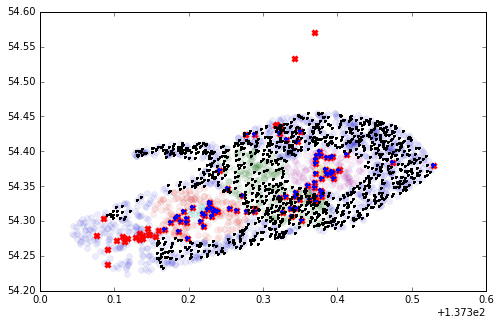

In [46]:
###REDO WITH ADDITION OF PHOTOZ 2 sigma range
mpld3.enable_notebook()

#Have to read in pickle file here


#t.cont_plot(grouped,False)

#cat_gq.set_index(['z_group','q_group','z_group_pz'],drop=False,inplace=True)
cat_gq.set_index(['z_group','q_group','slice','z_group_pz','z_group_pz2'],drop=False,inplace=True)

#cat_gq=cat_gq[(cat_gq.Z<=23.25)&(cat_gq.Z>=20.0)]
mag=((cat_gq.Z<=23.25)&(cat_gq.Z>=20.0))
#t.cont_plot(grouped,False)
sn2=((cat_gq.ftot_mips24/cat_gq.etot_mips24)>2.0)


print 'using dic (zip of bins3 and labels manually spec), will not plot unassigned',dic
#Still have to replace tis loop with inverse dic zip(colors,labels): for num in nums: print dic[num],num
for a,b,c in zip(labels,colors,bins3): #THIS WONT PLOT UNASSIGNED (which has tons/all of the un assigned photoz gals)  
    print 'plotting',a,c
    py.plot(cat_gq[(cat_gq.slice==a)&(cat_gq.Z<=23.25)].ra,cat_gq[(cat_gq.slice==a) &(cat_gq.Z<=23.25)].dec,b,ms=6,alpha=0.08) #Why so few now

    #py.plot(cat_gq[cat_gq.slice==a].xs(['pz'],level=['z_group_pz']).ra,cat_gq[cat_gq.slice==a].xs(['pz'],level=['z_group_pz']).dec,b,ms=2,alpha=1.0)
    
#py.plot(cat_gq[cat_gq.slice=='unassigned'].ra,cat_gq[cat_gq.slice=='unassigned'].dec,b,ms=2,alpha=0.1)



#cat_gq.set_index(['z_group','q_group','slice','z_group_pz'],drop=False,inplace=True)
#print cat_gq.xs(['high','cz'],level=['q_group','z_group']).sort('slice_i2').groupby('slice').size()
#print cat_gq.xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2').size()

for a,b in cat_gq.xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()
print '\n'
#py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=3,mew=5)

#for a,b in cat_gq[(cat_gq.LIR.notnull())].xs(['high','pz'],level=['q_group','z_group_pz2']).groupby('slice_i2'): 
print '\nAll 2 sig pz, including whichever have high q spectra'
for a,b in cat_gq[(cat_gq.LIR.notnull())&sn2].xs(['pz'],level=['z_group_pz2']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()

print '\nAll 2 sig pz, excluding!!!! whichever have high q spectra'
for a,b in cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&sn2].xs(['pz'],level=['z_group_pz2']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()

    
#mag=((cat_gq.Z<=23.25)&(cat_gq.Z>=20.0))
#sn2=((cat_gq.ftot_mips24/cat_gq.etot_mips24)>2.0)
#py.hist(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')].xs(['pz'],level=['z_group_pz2']).Z.dropna())


    
py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=5,mew=3)
#py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=5,mew=2)

#py.plot(cat_gq[(cat_gq.LIR.isnull())].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[(cat_gq.LIR.isnull())].xs(['high','cz'],level=['q_group','z_group']).dec,'k+',ms=5,mew=2)
py.plot(cat_gq[(cat_gq.LIR.notnull())].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[(cat_gq.LIR.notnull())].xs(['high','cz'],level=['q_group','z_group']).dec,'b+',ms=5,mew=2)

#All 2SIG PZ except for hq cz and pz, so include hq cz manually
#py.plot(cat_gq[(cat_gq.LIR.isnull())&(cat_gq.q_group!='high')].xs(['pz'],level=['z_group_pz2']).ra,cat_gq[(cat_gq.LIR.isnull())&(cat_gq.q_group!='high')].xs(['pz'],level=['z_group_pz2']).dec,'k+',ms=5,mew=2)
#Only in MF
py.plot(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')].xs(['pz','merger front'],level=['z_group_pz2','slice']).ra,cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')].xs(['pz','merger front'],level=['z_group_pz2','slice']).dec,'k+',ms=3,mew=2)
#Only in MB
py.plot(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')].xs(['pz','merger back'],level=['z_group_pz2','slice']).ra,cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')].xs(['pz','merger back'],level=['z_group_pz2','slice']).dec,'k+',ms=3,mew=2)
    
    
#Plot only high quality unassigned to see what's now missing from CMDs
#py.plot(cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=20,alpha=1)

#py.plot(cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=20,mew=2,alpha=1)

    
#Plot only values below mask size
#Height cut to improve completeness removes two high quality spectra. Should I include them anyway?
#I am already including objects 
#py.plot(cat_gq[cat_gq.yprime<=7.025].ra,cat_gq[cat_gq.yprime<=7.025].dec,'g.',ms=2)
#py.plot(cat_gq[cat_gq.yprime>7.025].xs(['pz'],level=['z_group_pz']).ra,cat_gq[cat_gq.yprime>7.025].xs(['pz'],level=['z_group_pz']).dec,'wo',ms=3,alpha=1)

#py.plot(cat_gq[cat_gq.yprime>7.025].ra,cat_gq[cat_gq.yprime>7.025].dec,'go',ms=1,alpha=1,mec='w')
#py.plot(cat_gq[cat_gq.yprime>7.025].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.yprime>7.025].xs(['high','cz'],level=['q_group','z_group']).dec,'wo',ms=20,alpha=1)

print cat_gq[cat_gq.LIR.notnull()].xs(['high','cz'],level=['q_group','z_group']).LIR.mean()
#print 'merger front mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).SFR_UVIR.values
#print 'merger back mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).SFR_UVIR.values

print 'merger front mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).LIR.mean()
print 'merger back mean',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).LIR.mean()
print 'merger front median',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger front'],level=['q_group','z_group','slice']).LIR.median()
print 'merger back median',cat_gq[cat_gq.LIR.notnull()].xs(['high','cz','merger back'],level=['q_group','z_group','slice']).LIR.median()

243
88
high q within cuts 24
Merger Back: 2sig pz and hq cz:
34
3
Merger Front: 2sig pz and hq cz:
8
4


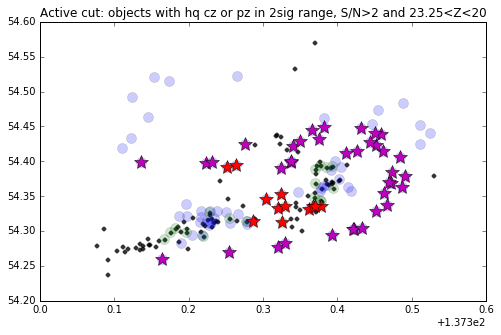

In [47]:
#ONLY HQ 2PZ range, excluding hq cz objects
#NO MAG CUT
#n,binss, patches=py.hist(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')].xs(['pz'],level=['z_group_pz2']).Z.dropna(),bins=50,alpha=0.7)
#MAG CUT
#print n.sum()
#py.hist(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag].xs(['pz'],level=['z_group_pz2']).Z.dropna(),bins=binss,alpha=0.7)
#print n.sum()
print len(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag].xs(['pz'],level=['z_group_pz2']).Z.dropna())

#SN CUT
#py.hist(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz'],level=['z_group_pz2']).Z.dropna(),bins=binss,alpha=0.7)
#py.close()
#py.hist(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz'],level=['z_group_pz2']).LIR.dropna(),bins=50,alpha=0.7)
print len(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz'],level=['z_group_pz2']).Z.dropna())

py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=3,mew=3,alpha=0.8)

py.plot(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz'],level=['z_group_pz2']).ra,cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz'],level=['z_group_pz2']).dec,'bo',ms=10,alpha=0.2)
#py.title('28 Non hq-spec objects with pz in 2sig range, S/N>2 and 23.25<Z<20')

py.plot(cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','high'],level=['z_group','q_group']).ra,cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','high'],level=['z_group','q_group']).dec,'go',ms=10,alpha=0.2)
#py.title('37, 12 MB, MF objects with hq cz or pz in 2sig range, S/N>2 and 23.25<Z<20')
py.title('Active cut: objects with hq cz or pz in 2sig range, S/N>2 and 23.25<Z<20')

print 'high q within cuts',len(cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','high'],level=['z_group','q_group']).Z.dropna())




#print len(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz'],level=['z_group_pz2']).Z.dropna())

#OK I need to make a mips coverage cut...maybe I should make a mask?
#Make a region file for ds9 to recalc the area
#cat_all[(cat_all.region_PG.notnull())&(cat_all.LIR.notnull())].to_csv('mips',sep='\t')


#SN CUT
#py.hist(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger back'],level=['z_group_pz2','slice']).Z.dropna(),bins=binss,alpha=0.7)

print 'Merger Back: 2sig pz and hq cz:'
py.plot(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger back'],level=['z_group_pz2','slice']).ra,cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger back'],level=['z_group_pz2','slice']).dec,'m*',ms=14)
py.plot(cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger back','high'],level=['z_group','slice','q_group']).ra,cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger back','high'],level=['z_group','slice','q_group']).dec,'m*',ms=14)

print len(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger back'],level=['z_group_pz2','slice']).Z.dropna())
print len(cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger back','high'],level=['z_group','slice','q_group']).Z.dropna())

py.plot(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger front'],level=['z_group_pz2','slice']).ra,cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger front'],level=['z_group_pz2','slice']).dec,'r*',ms=14)
py.plot(cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger front','high'],level=['z_group','slice','q_group']).ra,cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger front','high'],level=['z_group','slice','q_group']).dec,'r*',ms=14)

print 'Merger Front: 2sig pz and hq cz:'
#py.hist(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger front'],level=['z_group_pz2','slice']).Z.dropna(),bins=binss,alpha=0.7)
print len(cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger front'],level=['z_group_pz2','slice']).Z.dropna())
print len(cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger front','high'],level=['z_group','slice','q_group']).Z.dropna())





Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Errors using fractional I think, have to check back with Adam vs Brian methods:
23173656761.2 13828684137.2
12
sqrt(err^2 summed)*1.253/N 11468782264.0
sqrt(err^2 summed)*1.253/N 1.1668819164
MF_LIR_err_mean*1.253/N 0.852834223379
MF_LIR_err_median*1.253/N 0.508921626744

MB: (Just the error on median L_TIR)
33981747212.9 23345647508.5
37
MB sqrt(err^2 summed)*1.253/N 8530066261.64
sqrt(err^2 summed)*1.253/N 0.867884648713

MB_LIR_err_mean*1.253/N 0.712205815585
MB_LIR_err_median*1.253/N 0.489289318174
MF median converted to SFR 11.2289055233
MB median converted to SFR 14.6547238372
MF median 1.103641e+11
MB median 1.44035e+11
MF TAIL (nan, nan, pz)    5.355260e+10
(nan, nan, nz)    6.590000e+10
(nan, nan, nz)    7.562410e+10
(nan, nan, pz)    1.358450e+11
(nan, nan, pz)    1.889680e+11
Name: LIR, dtype: float64
MB TAIL (nan, nan, nz)    3.746610e+10
(nan, nan, nz)    3.891510e+10
(nan, nan, nz)    3.969280e+10
(nan, nan, pz)    5.135650e+10
(nan, nan, nz)    5.733450e+10
Name: LIR, dt

"\nprint '\nOnly apply this with high S/N, so uncomment low SN cut above, and depth cut'\nprint 'DROPPING for XRAY (1 and 6 to get to 65711000000.0 or 6.57e10) high SN for equal depth'\nprint 'MF med',np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna())[1:].median()\nprint 'MB med',np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna())[6:].median()\n#print '\nMF min',sort(np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()))[1:].count()\n#print 'MB min',sort(np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna()))[3:].count()\n#print 'MF median',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].median()\n#print 'MB median',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].median()\nprint 'MF mean',pd.concat([MF2sig,MFhq]).LIR.dropna()[1:].mean()\nprint 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].mean()\nprint 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna()[1:].count()\nprint 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].count()\nprint 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR[1:].dropna().count()/MFSA*(

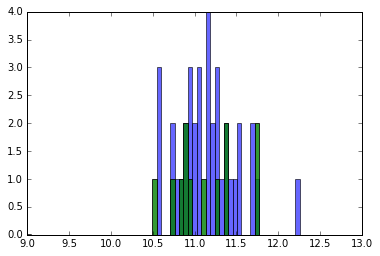

In [48]:
from scipy.stats import ks_2samp,kstest

mpld3.enable_notebook()
cat_gq.set_index(['z_group','q_group','slice','z_group_pz','z_group_pz2'],drop=False,inplace=True)

MFSA=91336.5
MBSA=267126.0
#MFSA=77568.8
#MBSA=288449.0


#MF2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger front'],level=['z_group_pz2','slice'])
#MFhq=cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger front','high'],level=['z_group','slice','q_group'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger back'],level=['z_group_pz2','slice'])
#MBhq=cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger back','high'],level=['z_group','slice','q_group'])

#np.log(cat_gq)
#With SN cut and mag cut
MF2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger front'],level=['z_group_pz2','slice']).sort_values(['LIR'])
MFhq=cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger front','high'],level=['z_group','slice','q_group']).sort_values(['LIR'])

MB2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag&sn2].xs(['pz','merger back'],level=['z_group_pz2','slice']).sort_values(['LIR'])
MBhq=cat_gq[(cat_gq.LIR.notnull())&mag&sn2].xs(['cz','merger back','high'],level=['z_group','slice','q_group']).sort_values(['LIR'])

#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(2.3)]
#MFhq=MFhq[MFhq.ftot_mips24>=10**(2.3)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(2.3)]
#MBhq=MBhq[MBhq.ftot_mips24>=10**(2.3)]

#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.9)]
#MFhq=MFhq[MFhq.ftot_mips24>=10**(1.9)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.9)]
#MBhq=MBhq[MBhq.ftot_mips24>=10**(1.9)]


#L_TIR DEPTH
%pylab inline
n,binss,patches=py.hist(np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna()),bins=75,alpha=0.6,range=[9,13])
py.hist(np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()),bins=binss,alpha=0.8)
#n,binss,patches=py.hist(pd.concat([MB2sig,MBhq]).LIR.dropna(),bins=25,alpha=0.6)
#py.hist(pd.concat([MF2sig,MFhq]).LIR.dropna(),bins=binss,alpha=0.8)
py.savefig('LTIRdepthhist.png')
'''
print 'WITH S/N>2 CUT'
print 'MF median',pd.concat([MF2sig,MFhq]).LIR.dropna().median()
print 'MB median',pd.concat([MB2sig,MBhq]).LIR.dropna().median()

print 'MF median SFR_UVIR',pd.concat([MF2sig,MFhq]).SFR_UVIR.dropna().median()
print 'MB median SFR_UVIR',pd.concat([MB2sig,MBhq]).SFR_UVIR.dropna().median()


print 'MF mean',pd.concat([MF2sig,MFhq]).LIR.dropna().mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna().mean()
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna().count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna().count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR.dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR.dropna().count()/MBSA*(60**2)
'''
#flux_24 / error_24 = L_TIR / error_L_TIR
#sn2=((cat_gq.ftot_mips24/cat_gq.etot_mips24)>2.0)
#cat_gq['LIR_err']=cat_gq.LIR / (cat_gq.ftot_mips24/cat_gq.etot_mips24)
#py.hist((cat_gq.ftot_mips24/cat_gq.etot_mips24).dropna())
#print (cat_gq['LIR_err']/cat_gq['LIR_err']).describe()



#Now add LIR errors in quad by squaring a column then summing then taking sqrt
#cat_gq['LIR_err2']=cat_gq['LIR_err'].apply(lambda x: pow(x,2).sum())
#cat_gq['LIR_err2']=cat_gq['LIR_err']*cat_gq['LIR_err']
#Add all uncertainties of the L_TIR values which go into each distribution (separately) in quadrature, divide by sqrt(N_gal), and multiply by 1.253
#print cat_gq['LIR_err'].dropna().T
#print np.sqrt( cat_gq['LIR_err2'].sum() )

'''
print '\nWITHOUT S/N>2 CUT'

MF2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag].xs(['pz','merger front'],level=['z_group_pz2','slice'])
MFhq=cat_gq[(cat_gq.LIR.notnull())&mag].xs(['cz','merger front','high'],level=['z_group','slice','q_group'])
MB2sig=cat_gq[(cat_gq.LIR.notnull())&(cat_gq.q_group!='high')&mag].xs(['pz','merger back'],level=['z_group_pz2','slice'])
MBhq=cat_gq[(cat_gq.LIR.notnull())&mag].xs(['cz','merger back','high'],level=['z_group','slice','q_group'])
'''

#print pd.concat([MF2sig,MFhq])['LIR_err'].dropna().T
#print MFhq['LIR_err'].dropna().T
#print np.sqrt( pd.concat([MF2sig,MFhq])['LIR_err2'].sum() )

#flux_24 / error_24 = L_TIR / error_L_TIR
#sn2=((cat_gq.ftot_mips24/cat_gq.etot_mips24)>2.0)
#cat_gq['LIR_err']=cat_gq.LIR / (cat_gq.ftot_mips24/cat_gq.etot_mips24)
#py.hist((cat_gq.ftot_mips24/cat_gq.etot_mips24).dropna())
#print (cat_gq['LIR_err']/cat_gq['LIR_err']).describe()
MF=pd.concat([MF2sig,MFhq]).reset_index()
MB=pd.concat([MB2sig,MBhq]).reset_index()
#MF[['id_phot','LIR','ftot_mips24','etot_mips24']].to_csv('MF_LTIR.tab',sep='\t',index=False)
#MB[['id_phot','LIR','ftot_mips24','etot_mips24']].to_csv('MB_LTIR.tab',sep='\t',index=False)
#MF.info()
MF['LIR_err']=MF.LIR / (MF.ftot_mips24/MF.etot_mips24) #Make uncertainty
MF_LIR_err_mean=(MF.LIR/(MF.ftot_mips24/MF.etot_mips24)).mean()
#Adam's error requires mean(f24err/f24*LTIR)/sqrt(n_elements(ID))
MF_LIR_err_median=(MF.LIR/(MF.ftot_mips24/MF.etot_mips24)).median()
print 'Errors using fractional I think, have to check back with Adam vs Brian methods:'
print MF_LIR_err_mean,MF_LIR_err_median


MF['frac']=MF.etot_mips24/MF.ftot_mips24
#print MF.frac
#print MF['LIR']
#print MF['LIR_err']
MF['LIR_err2']=MF['LIR_err']*MF['LIR_err'] #Square so can add in quad then sqrt
#print MF['LIR_err2']
#print MF['LIR_err2'].sum()
#print np.sqrt(MF['LIR_err2'].sum())
print MF['LIR_err2'].count()
#print np.sqrt(MF['LIR_err2'].count()) #divide by sqrt(N)
#print '1.253/sqrt(N)',1.253/np.sqrt(MF['LIR_err2'].count()) #divide by sqrt(N) *1.253
#print 'sqrt(err^2 summed)*1.253/sqrt(N)',np.sqrt(MF['LIR_err2'].sum())*1.253/np.sqrt(MF['LIR_err2'].count()) 
#print 'sqrt(err^2 summed)*1.253/sqrt(N)',(np.sqrt(MF['LIR_err2'].sum())*1.253/np.sqrt(MF['LIR_err2'].count()))*(1.75e-10/1.72)
print 'sqrt(err^2 summed)*1.253/N',np.sqrt(MF['LIR_err2'].sum())*1.253/len(MF['LIR_err2']) 
print 'sqrt(err^2 summed)*1.253/N',np.sqrt(MF['LIR_err2'].sum())*1.253/len(MF['LIR_err2'])*(1.75e-10/1.72)

print 'MF_LIR_err_mean*1.253/N',MF_LIR_err_mean*1.253/np.sqrt(len(MF['LIR_err2']))*(1.75e-10/1.72)
print 'MF_LIR_err_median*1.253/N',MF_LIR_err_median*1.253/np.sqrt(len(MF['LIR_err2']))*(1.75e-10/1.72)

print '\nMB: (Just the error on median L_TIR)'
MB['LIR_err']=MB.LIR / (MB.ftot_mips24/MB.etot_mips24) #Make uncertainty
MB['frac']=MB.etot_mips24/MB.ftot_mips24
MB_LIR_err_mean=(MB.LIR/(MB.ftot_mips24/MB.etot_mips24)).mean()
#Adam's error requires mean(f24err/f24*LTIR)/sqrt(n_elements(ID))
MB_LIR_err_median=(MB.LIR/(MB.ftot_mips24/MB.etot_mips24)).median()
print MB_LIR_err_mean,MB_LIR_err_median

#print MF.frac
#print MF['LIR']
#print MF['LIR_err']
MB['LIR_err2']=MB['LIR_err']*MB['LIR_err'] #Square so can add in quad then sqrt
#print MF['LIR_err2']
#print MF['LIR_err2'].sum()
#print np.sqrt(MF['LIR_err2'].sum())
print MB['LIR_err2'].count()
#print np.sqrt(MB['LIR_err2'].count()) #divide by sqrt(N)
#print '1.253/sqrt(N)',1.253/np.sqrt(MB['LIR_err2'].count()) #divide by sqrt(N) *1.253
#print 'sqrt(err^2 summed)*1.253/sqrt(N)',np.sqrt(MB['LIR_err2'].sum())*1.253/np.sqrt(MB['LIR_err2'].count()) 
#print 'sqrt(err^2 summed)*1.253/sqrt(N)',(np.sqrt(MB['LIR_err2'].sum())*1.253/np.sqrt(MB['LIR_err2'].count()))*(1.75e-10/1.72)
print 'MB sqrt(err^2 summed)*1.253/N',np.sqrt(MB['LIR_err2'].sum())*1.253/len(MB['LIR_err2'])
print 'sqrt(err^2 summed)*1.253/N',np.sqrt(MB['LIR_err2'].sum())*1.253/len(MB['LIR_err2'])*(1.75e-10/1.72)

print '\nMB_LIR_err_mean*1.253/N',MB_LIR_err_mean*1.253/np.sqrt(len(MB['LIR_err2']))*(1.75e-10/1.72)
print 'MB_LIR_err_median*1.253/N',MB_LIR_err_median*1.253/np.sqrt(len(MB['LIR_err2']))*(1.75e-10/1.72)


'''
print MF.frac.head()
#MF.LIR/MF['LIR_err'].head()
print MF['LIR'].head()
print MF['LIR_err'].head()
MF['LIR_err2']=MF['LIR_err']*MF['LIR_err'] #Square so can add in quad then sqrt
print MF['LIR_err2'].head()
print MF['LIR_err2'].head().sum()
print np.sqrt(MF['LIR_err2'].head().sum())
print MF['LIR_err2'].head().count()
print np.sqrt(MF['LIR_err2'].head().count()) #divide by sqrt(N)
print '1.253/sqrt(N)',1.253/np.sqrt(MF['LIR_err2'].head().count()) #divide by sqrt(N) *1.253
#*(1.75e-10/1.72)
print '1.253/sqrt(N)',np.sqrt(MF['LIR_err2'].head().sum())*1.253/np.sqrt(MF['LIR_err2'].head().count()) 
'''

#print '\n',np.sqrt( pd.concat([MF2sig,MFhq])['LIR_err2'].sum() ) / np.sqrt( pd.concat([MF2sig,MFhq])['LIR_err2'].count())*1.253

#print MBhq['LIR_err'].dropna().T
#print np.sqrt( pd.concat([MB2sig,MBhq])['LIR_err2'].sum() )
#print np.sqrt( pd.concat([MB2sig,MBhq])['LIR_err2'].sum() )/np.sqrt( pd.concat([MB2sig,MBhq])['LIR_err2'].count())*1.253

#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(2.3)]
#MFhq=MFhq[MFhq.ftot_mips24>=10**(2.3)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(2.3)]
#MBhq=MBhq[MBhq.ftot_mips24>=10**(2.3)]

#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.9)]
#MFhq=MFhq[MFhq.ftot_mips24>=10**(1.9)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.9)]
#MBhq=MBhq[MBhq.ftot_mips24>=10**(1.9)]

print 'MF median converted to SFR',pd.concat([MF2sig,MFhq]).LIR.dropna().median()*(1.75e-10/1.72)
print 'MB median converted to SFR',pd.concat([MB2sig,MBhq]).LIR.dropna().median()*(1.75e-10/1.72)

print 'MF median',pd.concat([MF2sig,MFhq]).LIR.median()
print 'MB median',pd.concat([MB2sig,MBhq]).LIR.median()

#print 'MF TAIL',sort(pd.concat([MF2sig,MFhq]).LIR.dropna()).head()
#print 'MB TAIL',sort(pd.concat([MB2sig,MBhq]).LIR.dropna()).head()
print 'MF TAIL',pd.concat([MF2sig,MFhq]).LIR.dropna().head()
print 'MB TAIL',pd.concat([MB2sig,MBhq]).LIR.dropna().head()


print '\nMF mean (converted to Chabrier in Lsol)',pd.concat([MF2sig,MFhq]).LIR.dropna().mean()*(1.75e-10/1.72)
print 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna().mean()*(1.75e-10/1.72)
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna().count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna().count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR.dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR.dropna().count()/MBSA*(60**2)

#Last question, plot f_nu for all SN>2 objects in MF and MB
#

#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(2.3)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(2.3)]
#print ks_2samp(MF2sig.ftot_mips24,MB2sig.ftot_mips24)
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger back'],level=['slice'])
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.0)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.0)]
#print ks_2samp(MF2sig.ftot_mips24,MB2sig.ftot_mips24)
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger back'],level=['slice'])
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.6)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.6)]
#print ks_2samp(MF2sig.ftot_mips24,MB2sig.ftot_mips24)
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&sn2&mag].xs(['merger back'],level=['slice'])
#MF2sig=MF2sig[MF2sig.ftot_mips24>=10**(1.8)]
#MB2sig=MB2sig[MB2sig.ftot_mips24>=10**(1.8)]
#print ks_2samp(MF2sig.ftot_mips24,MB2sig.ftot_mips24)
#the LTIR not null removes all objects not covered by mips:
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&mag].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&mag].xs(['merger back'],level=['slice'])
#Remove null 
#MF2sig=cat_gq[(cat_gq.LIR.notnull())&mag&(cat_gq.weight_mips24!=0)].xs(['merger front'],level=['slice'])
#MB2sig=cat_gq[(cat_gq.LIR.notnull())&mag&(cat_gq.weight_mips24!=0)].xs(['merger back'],level=['slice'])
'''
print 'Z cut, no redshift cut, no S/N cut: MF and MB'
#ftot_mips24 DEPTH
#n,binss,patches=py.hist(np.log10(MB2sig.etot_mips24.dropna()),bins=25,alpha=0.5)
#py.hist(np.log10(MF2sig.etot_mips24.dropna()),bins=binss,alpha=0.5)
n,binss,patches=py.hist(MB2sig.etot_mips24.dropna(),bins=50,alpha=0.5,range=[-0.01,500])
py.hist(MF2sig.etot_mips24.dropna(),bins=binss,alpha=0.5)
py.xlabel('etot_mips24',fontsize=20)
py.figure()
n,binss,patches=py.hist(MB2sig.ftot_mips24.dropna(),bins=50,alpha=0.5,range=[-0.01,600])
py.hist(MF2sig.ftot_mips24.dropna(),bins=binss,alpha=0.5)
py.xlabel('ftot_mips24',fontsize=20)
py.figure()
n,binss,patches=py.hist(MB2sig.weight_mips24.dropna(),bins=50,alpha=0.5,range=[-0.01,10])
py.hist(MF2sig.weight_mips24.dropna(),bins=binss,alpha=0.5)
py.xlabel('weight_mips24',fontsize=20)
'''
#print 'MF median',MF2sig.weight_mips24.median()
#print 'MB median',MB2sig.weight_mips24.median()

#n,binss,patches=py.hist(pd.concat([MF2sig,MFhq]).weight_mips24.dropna(),bins=25,alpha=0.5)
#py.hist(pd.concat([MB2sig,MBhq]).weight_mips24.dropna(),bins=binss,alpha=0.5)
#n,binss,patches=py.hist(MB2sig.weight_mips24.dropna(),bins=25,alpha=0.5)
#py.hist(MF2sig.weight_mips24.dropna(),bins=binss,alpha=0.5)

#I HAVE TO EDIT THIS AGAIN RUN WITHOUT DEPTH CUT TO FIG OUT DEPTCH CUT

#Ali edit post ref comment, uncommented to rerun with Optical centroidsfig
#print 'DROPPING for Optical (2 and 6 to get to 65711000000.0 or 6.57e10)'
#SORT??? before drop
print '\nMF med (log)',np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()).sort_values()[1:].median()
print 'MB med',np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna())[7:].sort_values().median()

print '\nMF med',pd.concat([MF2sig,MFhq]).LIR.dropna().sort_values()[1:].median()
print 'MB med',pd.concat([MB2sig,MBhq]).LIR.dropna().sort_values()[7:].median()
print 'MF mean Lsol',pd.concat([MF2sig,MFhq]).LIR.dropna().sort_values()[1:].mean()*(1.75e-10/1.72)
print 'MB mean Lsol',pd.concat([MB2sig,MBhq]).LIR.dropna().sort_values()[7:].mean()*(1.75e-10/1.72)
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna().sort_values()[1:].count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna().sort_values()[7:].count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR[1:].dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR[7:].dropna().count()/MBSA*(60**2)

print '\nMF mean (lmass)',pd.concat([MF2sig,MFhq]).lmass.dropna().sort_values()[1:].mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).lmass.dropna().sort_values()[7:].mean()

print '\nMF mean (lmass)',pd.concat([MF2sig,MFhq]).lmass.dropna().sort_values().mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).lmass.dropna().sort_values().mean()

'''
#Ali edit post ref comment, uncommented to rerun with Optical centroidsfig
print 'DROPPING for Optical (2 and 6 to get to 65711000000.0 or 6.57e10)'
print '\nMF med',np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna())[2:].median()
print 'MB med',np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna())[6:].median()
#print '\nMF min',sort(np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()))[1:].count()
#print 'MB min',sort(np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna()))[3:].count()
#print 'MF median',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].median()
#print 'MB median',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].median()
print 'MF mean',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].mean()
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR[2:].dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR[6:].dropna().count()/MBSA*(60**2)
'''

'''
print '\nOnly apply this with high S/N, so uncomment low SN cut above, and depth cut'
print 'DROPPING for XRAY (1 and 6 to get to 65711000000.0 or 6.57e10) high SN for equal depth'
print 'MF med',np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna())[1:].median()
print 'MB med',np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna())[6:].median()
#print '\nMF min',sort(np.log10(pd.concat([MF2sig,MFhq]).LIR.dropna()))[1:].count()
#print 'MB min',sort(np.log10(pd.concat([MB2sig,MBhq]).LIR.dropna()))[3:].count()
#print 'MF median',pd.concat([MF2sig,MFhq]).LIR.dropna()[2:].median()
#print 'MB median',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].median()
print 'MF mean',pd.concat([MF2sig,MFhq]).LIR.dropna()[1:].mean()
print 'MB mean',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].mean()
print 'MF count',pd.concat([MF2sig,MFhq]).LIR.dropna()[1:].count()
print 'MB count',pd.concat([MB2sig,MBhq]).LIR.dropna()[6:].count()
print 'MF count/arcmin^2',pd.concat([MF2sig,MFhq]).LIR[1:].dropna().count()/MFSA*(60**2)
print 'MB count/arcmin^2',pd.concat([MB2sig,MBhq]).LIR[6:].dropna().count()/MBSA*(60**2)
'''

#print 'MF median',sort(pd.concat([MF2sig,MFhq]).LIR.dropna()).T

#print 'MB median',sort(pd.concat([MB2sig,MBhq]).LIR.dropna()).T

#read adam's thing
#Check why median is lower after we cut out the lowest object in MF
#We weight by sqrt 2 because the median exposure time is twice that of MF...sigma equals sqrt(N)...or two?
#So cutting object with LTIR below X, or reducing depth in MB by sqrt(2)1-1.4 
#py.show()
#py.savefig('blah_Xray')

In [64]:
#Above: We cut a few objects by forcing equal depth and still found that number density 

In [65]:
#Now with PZ
mpld3.enable_notebook()

#Have to read in pickle file here


#t.cont_plot(grouped,False)

cat_gq.set_index(['z_group','q_group','z_group_pz'],drop=False,inplace=True)

print 'using dic (zip of bins3 and labels manually spec), will not plot unassigned',dic
#Still have to replace tis loop with inverse dic zip(colors,labels): for num in nums: print dic[num],num
for a,b,c in zip(labels,colors,bins3): #THIS WONT PLOT UNASSIGNED (which has tons/all of the un assigned photoz gals)  
    print 'plotting',a,c
    py.plot(cat_gq[(cat_gq.slice==a)&(cat_gq.Z<=23.25)&(cat_gq.z_group_pz=='pz')].ra,cat_gq[(cat_gq.slice==a) &(cat_gq.Z<=23.25)&(cat_gq.z_group_pz=='pz')].dec,b,ms=6,alpha=0.4) #Why so few now

    #py.plot(cat_gq[cat_gq.slice==a].xs(['pz'],level=['z_group_pz']).ra,cat_gq[cat_gq.slice==a].xs(['pz'],level=['z_group_pz']).dec,b,ms=2,alpha=1.0)
    
#py.plot(cat_gq[cat_gq.slice=='unassigned'].ra,cat_gq[cat_gq.slice=='unassigned'].dec,b,ms=2,alpha=0.1)



cat_gq.set_index(['z_group','q_group','slice','z_group_pz'],drop=False,inplace=True)
#print cat_gq.xs(['high','cz'],level=['q_group','z_group']).sort('slice_i2').groupby('slice').size()
#print cat_gq.xs(['high','cz'],level=['q_group','z_group']).groupby('slice_i2').size()

for a,b in cat_gq[(cat_gq.Z<=23.25)].xs(['pz'],level=['z_group_pz']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()
print '\n'
#py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=3,mew=5)


#ALL PZ in PZ range, mag range have SFR_UVIR values
for a,b in cat_gq[(cat_gq.Z<=23.25)&cat_gq.SFR_UVIR.notnull()].xs(['pz'],level=['z_group_pz']).groupby('slice_i2'): 
    print a,b.slice_i2.unique(),b.slice.unique(),b.slice_i2.count()
print '\n'

py.plot(cat_gq.xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq.xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=5,mew=1)
py.plot(cat_gq[cat_gq.SFR_UVIR.isnull()].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.SFR_UVIR.isnull()].xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=7,mew=3)
    
    
#Plot only high quality unassigned to see what's now missing from CMDs
#py.plot(cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i2=='7'].xs(['high','cz'],level=['q_group','z_group']).dec,'kx',ms=20,alpha=1)

#py.plot(cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.slice_i34=='merger front 3_4'].xs(['high','cz'],level=['q_group','z_group']).dec,'rx',ms=20,mew=2,alpha=1)

    
#Plot only values below mask size
#Height cut to improve completeness removes two high quality spectra. Should I include them anyway?
#I am already including objects 
#py.plot(cat_gq[cat_gq.yprime<=7.025].ra,cat_gq[cat_gq.yprime<=7.025].dec,'g.',ms=2)
#py.plot(cat_gq[cat_gq.yprime>7.025].xs(['pz'],level=['z_group_pz']).ra,cat_gq[cat_gq.yprime>7.025].xs(['pz'],level=['z_group_pz']).dec,'wo',ms=3,alpha=1)

#py.plot(cat_gq[cat_gq.yprime>7.025].ra,cat_gq[cat_gq.yprime>7.025].dec,'go',ms=1,alpha=1,mec='w')
#py.plot(cat_gq[cat_gq.yprime>7.025].xs(['high','cz'],level=['q_group','z_group']).ra,cat_gq[cat_gq.yprime>7.025].xs(['high','cz'],level=['q_group','z_group']).dec,'wo',ms=20,alpha=1)

print cat_gq[cat_gq.SFR_UVIR.notnull()].xs(['high','pz'],level=['q_group','z_group_pz']).SFR_UVIR.mean()
print 'FOR PZ OBJECTS: merger front mean',cat_gq[cat_gq.SFR_UVIR.notnull()].xs(['high','pz','merger front'],level=['q_group','z_group_pz','slice']).SFR_UVIR.mean()
print 'merger back mean',cat_gq[cat_gq.SFR_UVIR.notnull()].xs(['high','pz','merger back'],level=['q_group','z_group_pz','slice']).SFR_UVIR.mean()
print 'merger front median',cat_gq[cat_gq.SFR_UVIR.notnull()].xs(['high','pz','merger front'],level=['q_group','z_group_pz','slice']).SFR_UVIR.median()
print 'merger back median',cat_gq[cat_gq.SFR_UVIR.notnull()].xs(['high','pz','merger back'],level=['q_group','z_group_pz','slice']).SFR_UVIR.median()

using dic (zip of bins3 and labels manually spec), will not plot unassigned {'infall B': '2', 'infall A': '5', 'core B': '3', 'core A': '6', 'merger back': '1', 'merger front': '4'}


TypeError: zip argument #2 must support iteration

In [78]:
'''
Will need to re-run this. grouped is already in pickle.
Make int before read into contours
grouped=cont.groupby(level=0)
filename='contPG.pickle'
f=open('/Users/alison/DLS/deimosspectracatalog/sandbox/deimosred/'+filename,'wb')
pickle.dump(cont,f)
'/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/region_stuff/contPG.pickle' 

f='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/region_stuff/contPG.pickle'
cont=pd.read_pickle(f)
grouped=cont.groupby(level=0)
#t.cont_plot(grouped,False)

cat_all.id=cat_all.id.astype('int')
cat_all.set_index('id',drop=False,inplace=True)
cat_all['alpha']=cat_all.ra
cat_all['delta']=cat_all.dec
PG_slitmasks=grouped.apply(t.ppoly,cat_all[['id','alpha','delta']])
#contour N= 25 , # 0 contains: 20710 gals out of 91388
PG_slitmasks.info()
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20710 entries, (0, 19907) to (0, -1)
Data columns (total 5 columns):
id         20710 non-null int64
alpha      20710 non-null float64
delta      20710 non-null float64
N          20710 non-null int64
contour    20710 non-null int64
dtypes: float64(2), int64(3)
memory usage: 1.0+ MB

cat_all=t.reg_contour_PG(cat_all,PG_slitmasks)
py.plot(cat_all[cat_all.region_PG.notnull()].ra,cat_all[cat_all.region_PG.notnull()].dec,'co',ms=2)
py.plot(cat_all[cat_all.region_PG.isnull()].ra,cat_all[cat_all.region_PG.isnull()].dec,'bo',ms=1)

So, before any completeness calculations:
cat_all=cat_all[cat_all.region_PG.notnull()] 




'''


"\nWill need to re-run this. grouped is already in pickle.\nMake int before read into contours\ngrouped=cont.groupby(level=0)\nfilename='contPG.pickle'\nf=open('/Users/alison/DLS/deimosspectracatalog/sandbox/deimosred/'+filename,'wb')\npickle.dump(cont,f)\n'/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/region_stuff/contPG.pickle' \n\nf='/Users/alison/DLS/deimosspectracatalog/spectrastack/briansprog/preElgordo/Pre_elGordo_paper/cats/region_stuff/contPG.pickle'\ncont=pd.read_pickle(f)\ngrouped=cont.groupby(level=0)\n#t.cont_plot(grouped,False)\n\ncat_all.id=cat_all.id.astype('int')\ncat_all.set_index('id',drop=False,inplace=True)\ncat_all['alpha']=cat_all.ra\ncat_all['delta']=cat_all.dec\nPG_slitmasks=grouped.apply(t.ppoly,cat_all[['id','alpha','delta']])\n#contour N= 25 , # 0 contains: 20710 gals out of 91388\nPG_slitmasks.info()\n<class 'pandas.core.frame.DataFrame'>\nMultiIndex: 20710 entries, (0, 19907) to (0, -1)\nData columns (tota

Populating the interactive namespace from numpy and matplotlib
z_group
cz    109
nz    882
dtype: int64
q_group
high    102
low       7
dtype: int64


`%matplotlib` prevents importing * from pylab and numpy


q_group
high    [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
low     [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
dtype: object

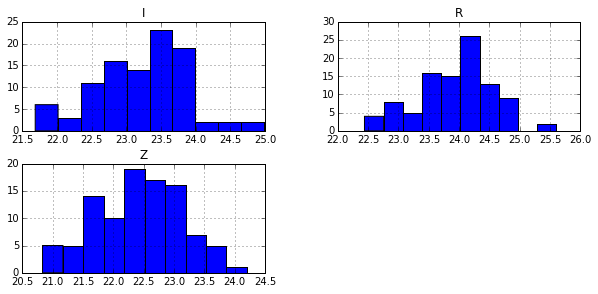

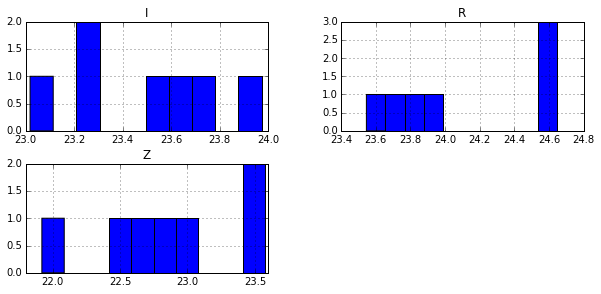

In [204]:
#mpld3.enable_notebook()
%pylab inline
#mag=['R','I','Z','Rerr','Ierr','Zerr','q_group']
mag=['R','I','Z'] #For histogram must ignore -99 and inf values
#cat_all.loc[cat_all.R<-5].info()
print cat_all.groupby(level=0).size()
print cat_all.xs(['cz'],level=['z_group']).groupby(level=0).size()
py.rcParams['figure.figsize'] = (10, 4.5)
#All qualities, at cluster redshift
cat_all[mag].xs(['cz'],level=['z_group']).groupby(level=0).hist(bins=10,fontsize=0.05,alpha=0.1)


z_group  q_group
cz       high        98
         low          7
nz       high       577
         low        221
         star        27
dtype: int64


q_group
high    [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
low     [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
star    [[Axes(0.125,0.563043;0.336957x0.336957), Axes...
dtype: object

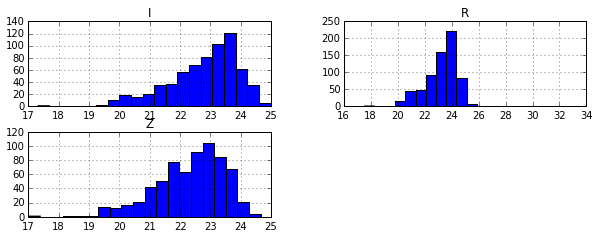

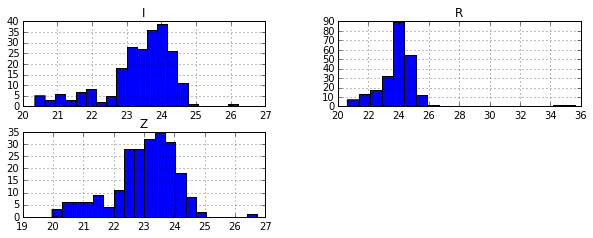

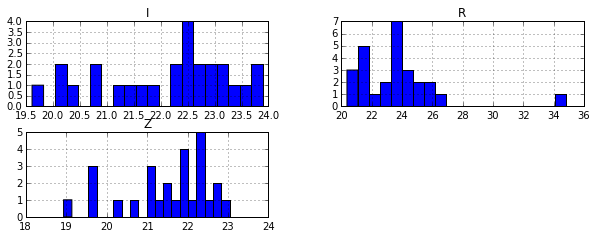

In [197]:
py.rcParams['figure.figsize'] = (10, 3.5)
print cat_all[mag].loc[(cat_all.R>-5)].replace([np.inf, '-99',-99], np.nan).groupby(level=[0,1]).size()
cat_all[mag].loc[(cat_all.R>-5)].replace([np.inf, '-99',-99], np.nan).groupby(level=[1]).hist(bins=20)
#py.savefig('blah')

In [112]:
cat_all.groupby(['z_group','q_group']).size()

z_group  q_group
cz       high       102
         low          7
nz       high       600
         low        234
         star        48
dtype: int64

In [ ]:
#cat_all.to_csv('cat_all_PG.tab',sep='\t',index=False,na_rep=NULL)

In [ ]:
#Mag cut on photometric objects based on spectroscopic objects
#cat_g.xs(['in'],level='z_group').groupby('q').hist()
#cat_g.g.groupby('z_group').hist()

#Same photoz stats with and without mag cut

In [ ]:
#Is zspec for cat_mag based in specid in crossmatch, so duplicates are messed up? should I not use this?
#Mag_total = Mag_aper + apercorr #add for each band
#cat_mag[cat_mag.z_spec>0]
#cat_mag=cat_mag[cat_mag.use==1] #Filter out flag use=0
#Clip out objects fainter than limiting mag of spectral sample (observed or final cut?)

#This will not merge correctly for duplicate objects in crossmatch
#So need to merger old spec cat with specID

#Merging new .crossmatch with old ID spec cat that has LFCriz
#.crossmatch also has id_phot...
#cat_g=cat_g.merge(cat_o,how='outer',left_index=True,right_index=True,on='id_spec')
#Now the nmatch=2 specIDs are paired with riz, but need new RIZ to compare photometry

#cat_mpz id is id_phot and also index. cat_g id_spec is index, but also has id_phot.
#cat_mpz=cat_mag.merge(cat_pz,how='outer',left_index=True,right_index=True,on='id',suffixes=('_m','_pz'))

#cat_g id created to store id_phot for merging with photo id from cat_mpz
#This won't work for new crossmatch because id_phot are both listed (,) for nmatch=2
#So need to merge on something else
#cat_g['id']=cat_g['id_phot']
#cat_g id/index is currently id_spec
#cat_g.set_index('id',drop=False,inplace=True)
#crossmatch
#cat_g.merge(cat_mpz,how='outer',left_index=True,right_index=True,on='id').info()

#blah=cat_g.merge(cat_mpz,how='outer',left_index=True,right_index=True,on='id')

#NOTE: The z_spec in z_spec_m has an extra significant digit (5), pz is rounded to 6, cat_g zspec has 6
#cat_mpz[cat_mpz.z_spec_m!=cat_mpz.z_spec_pz][['z_spec_m','z_spec_pz']] #so only use zspec from crossmatch...or brian's

In [ ]:
#print cat_g[cat_g.nmatch==2]
#print blah[blah.id==38941][['I','magaper_Iplus','nmatch']]
#print blah[blah.id==39005][['I','magaper_Iplus','nmatch']]
#print cat_g[cat_g.nmatch==2]
# 53820,54163
#print blah[blah.id==53820][['I','magaper_Iplus','nmatch']]
#print blah[blah.id==54163][['I','magaper_Iplus','nmatch']]

#Check that scinot read in
#Check duplicates and int: read in slit as string, remove s make into separate column then make int
#There are only 5 duplicates.
#Two have the same id_spec=5878, one of which is a serendip, both q=4
#cat_g[cat_g.duplicated(['id_phot'])|cat_g.duplicated(['id_phot'],take_last=True)].id_phot
#cat_g[cat_g.duplicated(['id_phot'])|cat_g.duplicated(['id_phot'],take_last=True)][['id_spec','id_phot','maskname']]
#cat_g[cat_g.duplicated(['id_phot','slitmask'])|cat_g.duplicated(['id_phot','slitmask'],take_last=True)][['id_spec','id_phot','slitmask','nmatch','slitnum','blend']]
#Make these into two entries and manually assign one f the id_phots to each
#For example, 
#One of these objects is T08_LRIS which means we don't actually have spectrum but have specz redshift and catalog from T08 paper

In [ ]:
#ID_SPEC with two ID_PHOT matches (due to astrometrics)
#5878 0910C.91 matches up to Adam's ID=54040 
#5878 0910C.91s matches up to Adam's ID=54230
#7766    0910MB      84 matches id_phot 63743
#2917    0910HT      23  matches id_phot 38941
#5922  T08_LRIS    1940 matches id_phot 54163
#Serendip q=4 inside cluster redshift slit 0910 31 and 31s is correctly matched to spectrum
#Only three potential co-add objects do not have phot matches, one of which we have no spectrum for
#So CMDs should only be missing two of our spectral sample objects (0910MB_089s,3909,5808 T08)
#print cat_g[((cat_g.z_spec<=1.12)&(cat_g.z_spec>=1.09)&(cat_g.id_phot=='-1')&(cat_g.Q>2))]

#How many objects have high quality spectra but no id_phot? They will go into co-adds...
#Note that id_phot is not integer...so -1 is string below in condition
#print cat_g[((cat_g.z_spec<=1.12)&(cat_g.z_spec>=1.09)&(cat_g.id_phot!='-1')&(cat_g.Q>2)&(cat_g.duplicated(['id_phot','slitmask'])|cat_g.duplicated(['id_phot','slitmask'],take_last=True)))]
#Make sure the photometry matches these objects and not the serendip that is at another redshift
#print cat_g[cat_g.id_spec=='2252']
#print cat_g[cat_g.id_spec=='4650'] #:
#I should check the spectroscopy on this one in zspec to make sure the photometry/photoz match
#print blah[blah.id==48362][['I','magaper_Iplus','nmatch']]